In [74]:
%matplotlib notebook

import pickle

from tqdm import tqdm
import numpy as np
import torch
from torcheval.metrics.functional import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy
from torch.utils.data import TensorDataset, DataLoader

from sklearn import datasets, manifold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

In [90]:
def data_range_shape(data: np.ndarray):
    print(data.shape)
    print(data)
    print(f"Value Range: [{np.min(data)}:{np.max(data)}]")
    
def label_range_shape(label: np.ndarray):
    print(label.shape)
    print(label)
    uniques, counts = np.unique(label, return_counts=True)
    total = sum(counts)
    lab = []
    nums = []
    ratios = []
    infos = []
    for unique, count in zip(uniques, counts):
        lab.append(unique)
        nums.append(count)
        ratios.append(count / total)
        infos.append(f"{count} ({str(round(count / total * 100, 2))}%)")
    print(f"Class Num: {np.unique(label)}, {dict(zip(uniques, infos))}")
    
def data_amplify(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, amplify: None):
    duplication = 1
    uniques = np.unique(y_train)
    if amplify is None:
        duplication = [1] * uniques
    elif isinstance(amplify, int):
        duplication = [amplify] * uniques
    elif isinstance(amplify, list):
        if len(amplify) == 1:
            duplication = [amplify] * uniques
        elif len(amplify) != uniques:
            raise ValueError(f'the length of amplify list should be the same as the number of unique values')
        else:
            duplication = amplify
    else:
        raise TypeError(f'amplify should be None, int, or list, not {type(amplify)}')
    
def cofusion_matrix(clf, X_test: np.array, y_test: np.array):
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            display_labels=[0, 1, 2],
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    
def plot_importance(importances: np.array, clf=None):
    if clf != None:
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    forest_importances = pd.Series(importances)

    fig, ax = plt.subplots()
    if clf != None:
        forest_importances.plot.bar(yerr=std, ax=ax)
    else:
        forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    
def correlation_map(data):
    d = pd.DataFrame(data=data, columns=list(range(data.shape[1])))

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(12, 12),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def evaluate_model(clf, eval_data: np.array, eval_labels: np.array, train_data: np.array, train_labels: np.array):
    # Testing Dataset
    eval_pred_label = clf.predict(eval_data)
    eval_acc: float = accuracy_score(eval_labels, eval_pred_label)
    eval_f1: float = f1_score(eval_labels, eval_pred_label, average='weighted')
    eval_precision: float = precision_score(eval_labels, eval_pred_label, average='weighted')
    eval_recall: float = recall_score(eval_labels, eval_pred_label, average='weighted')
    print(f"Test Acc: {eval_acc:.3f}, Test F1: {eval_f1:.3f}, Test Precision: {eval_precision:.3f}, Test Recall: {eval_recall:.3f}")
    cofusion_matrix(clf, eval_data, eval_labels)

    # Training Dataset
    train_pred_label = clf.predict(train_data)
    train_acc: float = accuracy_score(train_labels, train_pred_label)
    train_f1: float = f1_score(train_labels, train_pred_label, average='weighted')
    train_precision: float = precision_score(train_labels, train_pred_label, average='weighted')
    train_recall: float = recall_score(train_labels, train_pred_label, average='weighted')
    print(f"Train Acc: {train_acc:.3f}, Train F1: {train_f1:.3f}, Train Precision: {train_precision:.3f}, Train Recall: {train_recall:.3f}")
    cofusion_matrix(clf, train_data, train_labels)
    return eval_acc, eval_f1, train_acc, train_f1

def xgb_gridsearch(params: dict, file_name: str, X_train: np.array, y_train: np.array):
    gsearch = GridSearchCV(estimator = XGBClassifier(n_estimators=100, objective='multi:softmax', seed=27), 
     param_grid=params, scoring='f1_weighted', n_jobs=-1, cv=5)
    gsearch.fit(X_train, y_train)

    with open(f'{file_name}.pkl', 'wb') as f:
        pickle.dump(gsearch, f, pickle.HIGHEST_PROTOCOL)
    with open(f'{file_name}.pkl', 'rb') as f:
        grid_search = pickle.load(f)
    print(f"{file_name} | Best Param: {grid_search.best_params_}")
    print(f"{file_name} | Best Score: {grid_search.best_score_}")
    return grid_search

def pca_trans(n_components: int, X_train: np.array, X_test: np.array):
    pca = PCA(n_components=n_components).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    data_range_shape(X_train_pca)
    return X_train_pca, X_test_pca

def iso_trans(X_train: np.array, y_train: np.array):
    iso = IsolationForest(n_estimators=100, random_state=0, n_jobs=-1, warm_start=True).fit(X_train)
    outliner_idxs = iso.predict(X_train)
    X_train_iso = X_train[outliner_idxs == 1]
    y_train_iso = y_train[outliner_idxs == 1]

    data_range_shape(X_train_iso)
    data_range_shape(y_train_iso)
    return X_train_iso, y_train_iso

# Load Dataset

In [64]:
train_data = np.load('Test/train_data.npy')
data_range_shape(data=train_data)

train_labels = np.load('Test/train_labels.npy')
label_range_shape(label=train_labels)

(1174461, 70)
[[ 0.85 -0.71  0.14 ...  0.35  0.39  0.06]
 [ 1.13 -0.03  0.14 ...  0.35  0.39  0.06]
 [ 0.76 -0.03  0.14 ...  0.35  0.39  0.06]
 ...
 [ 0.33 -0.79 -0.24 ...  0.24  0.36  0.03]
 [ 0.33  1.54 -0.24 ...  0.24  0.36  0.03]
 [-0.69  0.02 -0.05 ...  0.24  0.36  0.03]]
Value Range: [-23.281249999999996:3399900.0]
(1174461,)
[1 1 0 ... 1 1 0]
Class Num: [0 1 2], {0: '637044 (54.24%)', 1: '256946 (21.88%)', 2: '280471 (23.88%)'}


In [65]:
eval_data = np.load('Test/eval_data.npy')
data_range_shape(data=eval_data)

eval_labels = np.load('Test/eval_labels.npy')
label_range_shape(label=eval_labels)

(1175302, 70)
[[-0.16  1.73  0.14 ...  0.26  0.32  0.03]
 [-0.06  1.52  0.14 ...  0.26  0.32  0.03]
 [-0.16  1.52  0.14 ...  0.26  0.32  0.03]
 ...
 [-1.08  0.03  0.13 ...  0.24  0.36  0.02]
 [-0.45  0.03  0.13 ...  0.24  0.36  0.02]
 [-1.56  0.23  0.13 ...  0.24  0.36  0.02]]
Value Range: [-208.31396230799652:205000.0]
(1175302,)
[1 1 1 ... 2 2 0]
Class Num: [0 1 2], {0: '635393 (54.06%)', 1: '249039 (21.19%)', 2: '290870 (24.75%)'}


# Scale with Standard Scaler

In [66]:
sc = StandardScaler().fit(train_data)
train_data_sc = sc.transform(train_data)
eval_data_sc = sc.transform(eval_data)
data_range_shape(train_data_sc)

(1174461, 70)
[[ 0.85 -0.71  0.14 ...  0.59  0.37  0.39]
 [ 1.13 -0.03  0.14 ...  0.59  0.37  0.39]
 [ 0.76 -0.03  0.14 ...  0.59  0.37  0.39]
 ...
 [ 0.33 -0.79 -0.24 ... -0.21 -0.18 -0.26]
 [ 0.33  1.54 -0.24 ... -0.21 -0.18 -0.26]
 [-0.69  0.02 -0.05 ... -0.21 -0.18 -0.26]]
Value Range: [-60.85795064477092:791.5795519580987]


# Check with XGBoost

In [30]:
xgboostModel = XGBClassifier(n_estimators=100, max_depth=20)
xgboostModel.fit(train_data_sc, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Importance Analysis
As we can see, most of feautures are useless. Thus, I decide to compress the dimensions of the dataset with PCA.


<IPython.core.display.Javascript object>


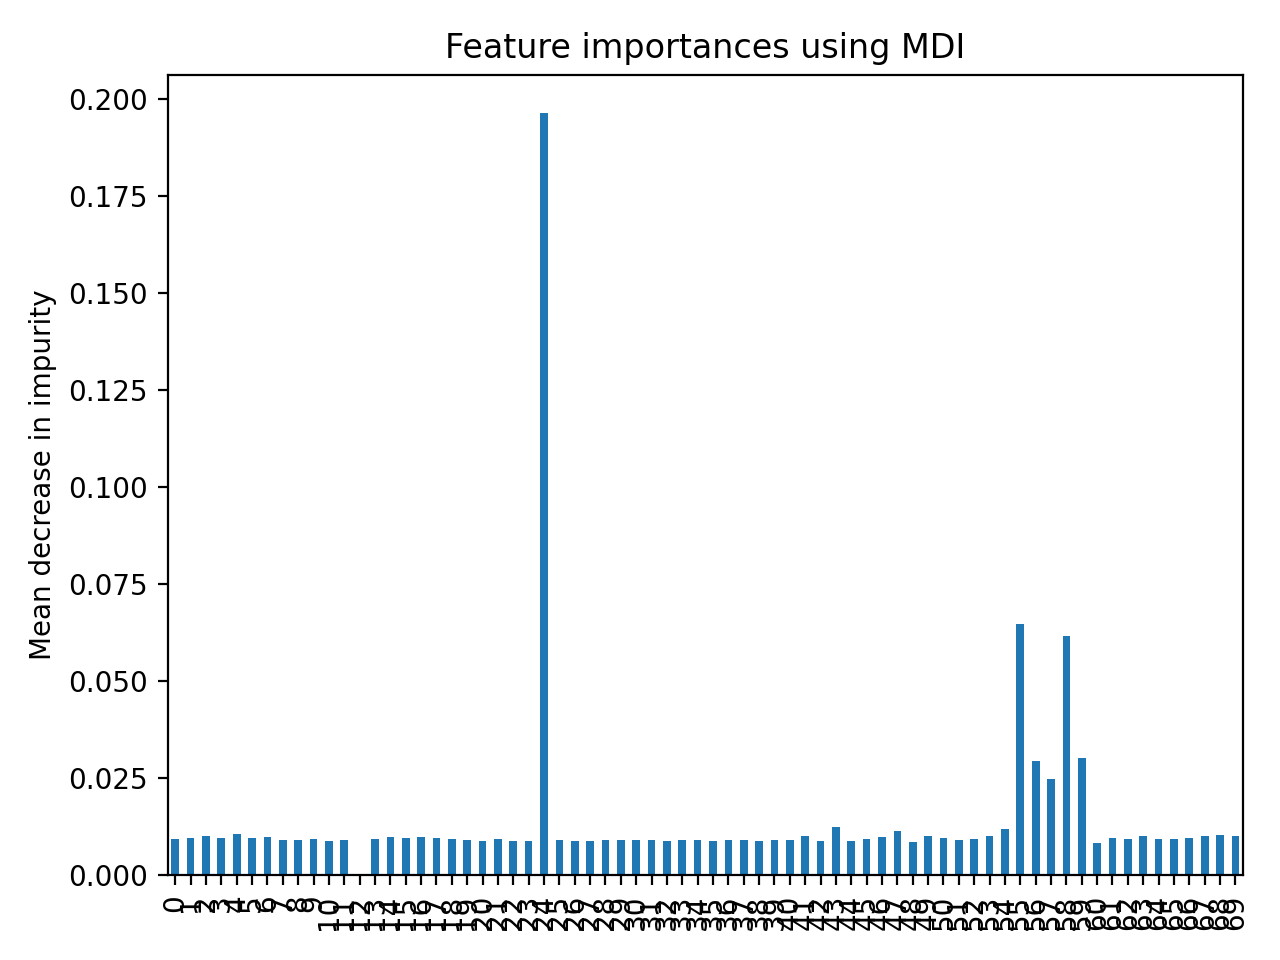

In [31]:
importances = xgboostModel.feature_importances_
plot_importance(importances=importances)

## Overfitting
Because the testing accuracy and F1-Score are much lower than the training accuracy and F1-Score, we focus on how to eliminate the overfitting. In the mean time, the confusion matrix shows that the classifier is hard to classify the samples of the class 1 and 2 correctly.

Test Acc: 0.5836984877078402, Test F1: 0.5760067962875496


<IPython.core.display.Javascript object>


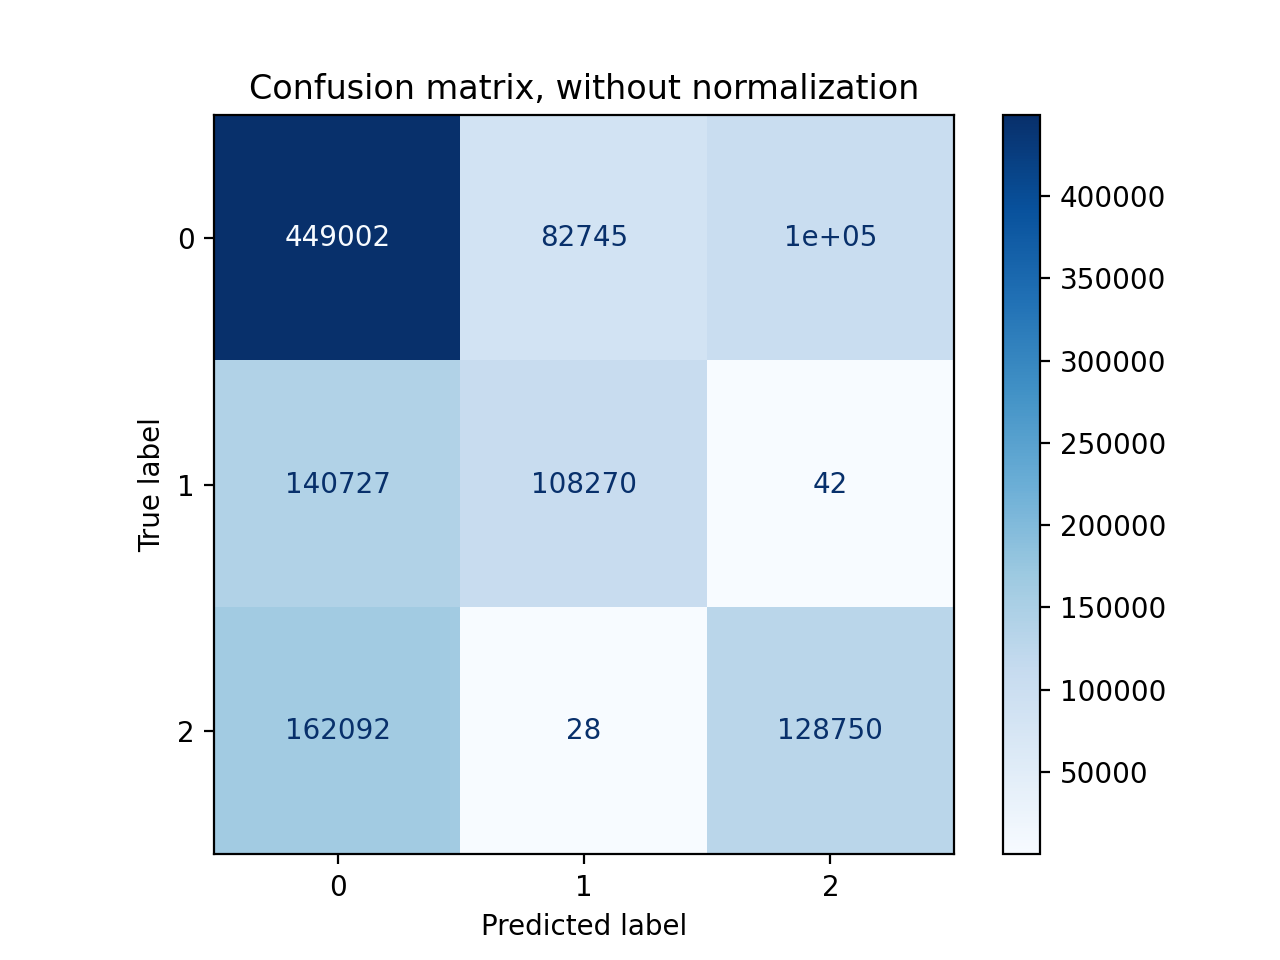

Confusion matrix, without normalization
[[449002  82745 103646]
 [140727 108270     42]
 [162092     28 128750]]


<IPython.core.display.Javascript object>


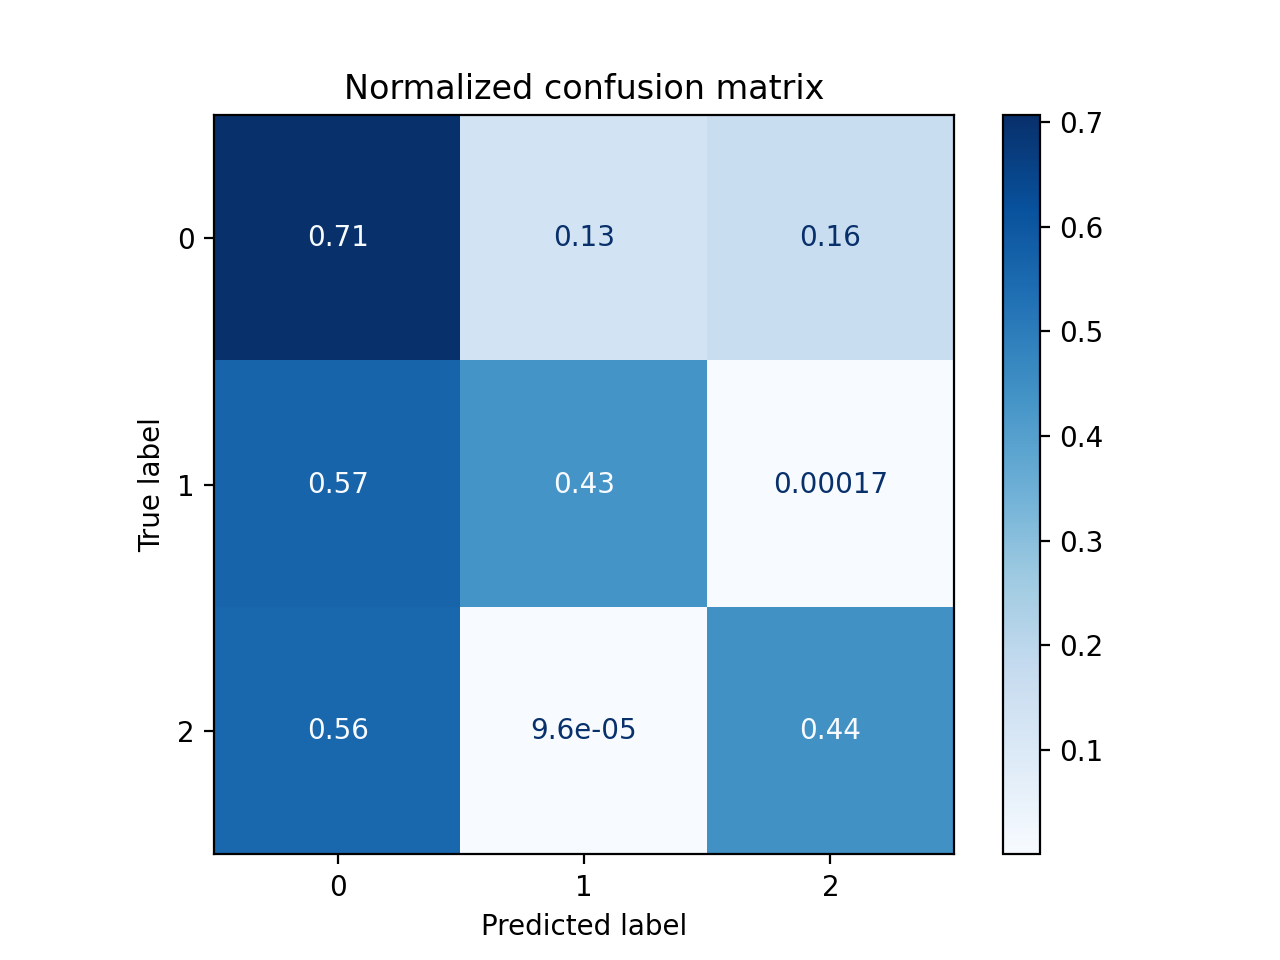

Normalized confusion matrix
[[7.07e-01 1.30e-01 1.63e-01]
 [5.65e-01 4.35e-01 1.69e-04]
 [5.57e-01 9.63e-05 4.43e-01]]
Train Acc: 1.0, Train F1: 1.0


<IPython.core.display.Javascript object>


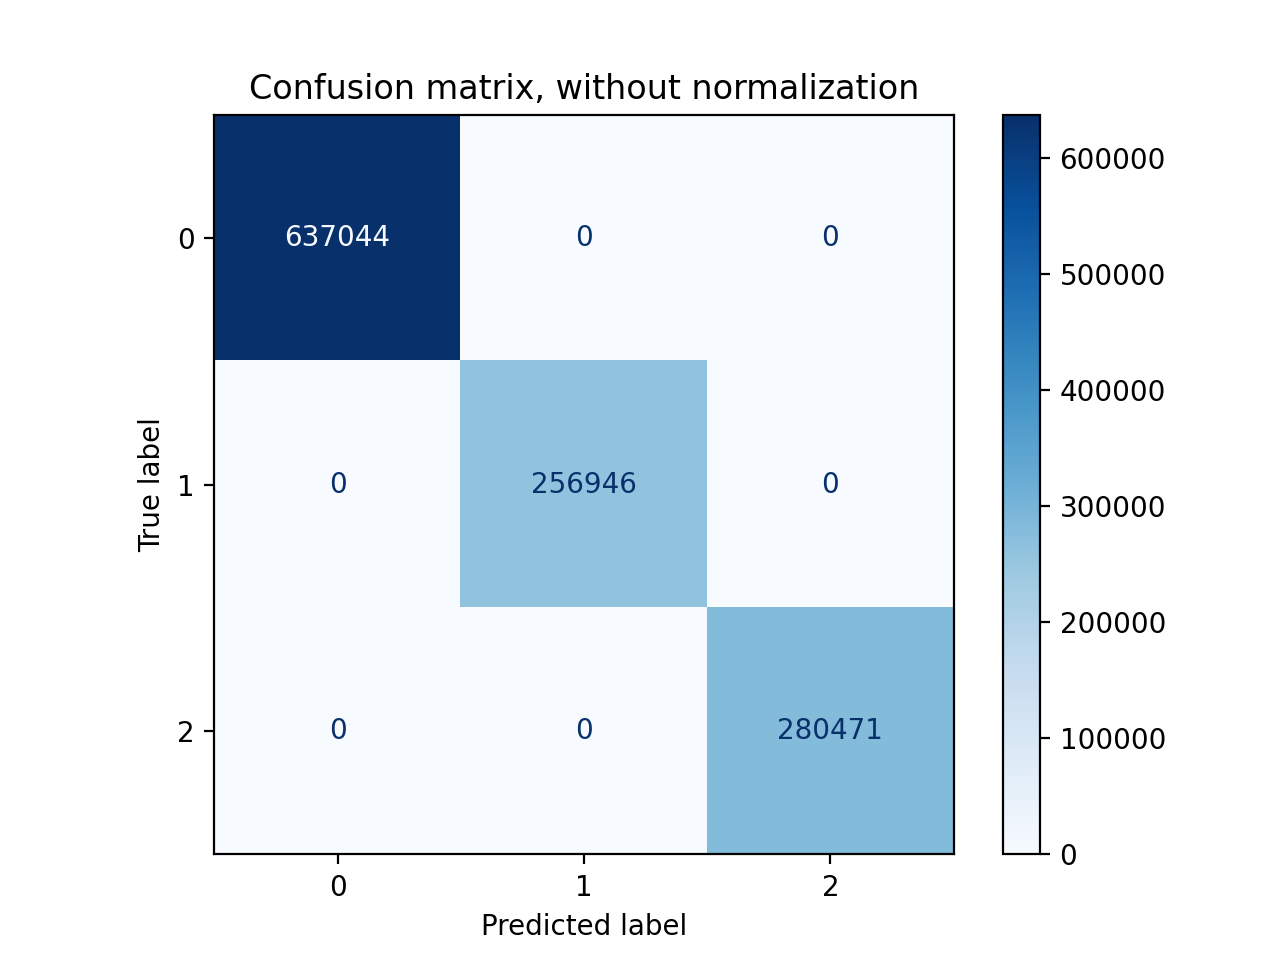

Confusion matrix, without normalization
[[637044      0      0]
 [     0 256946      0]
 [     0      0 280471]]


<IPython.core.display.Javascript object>


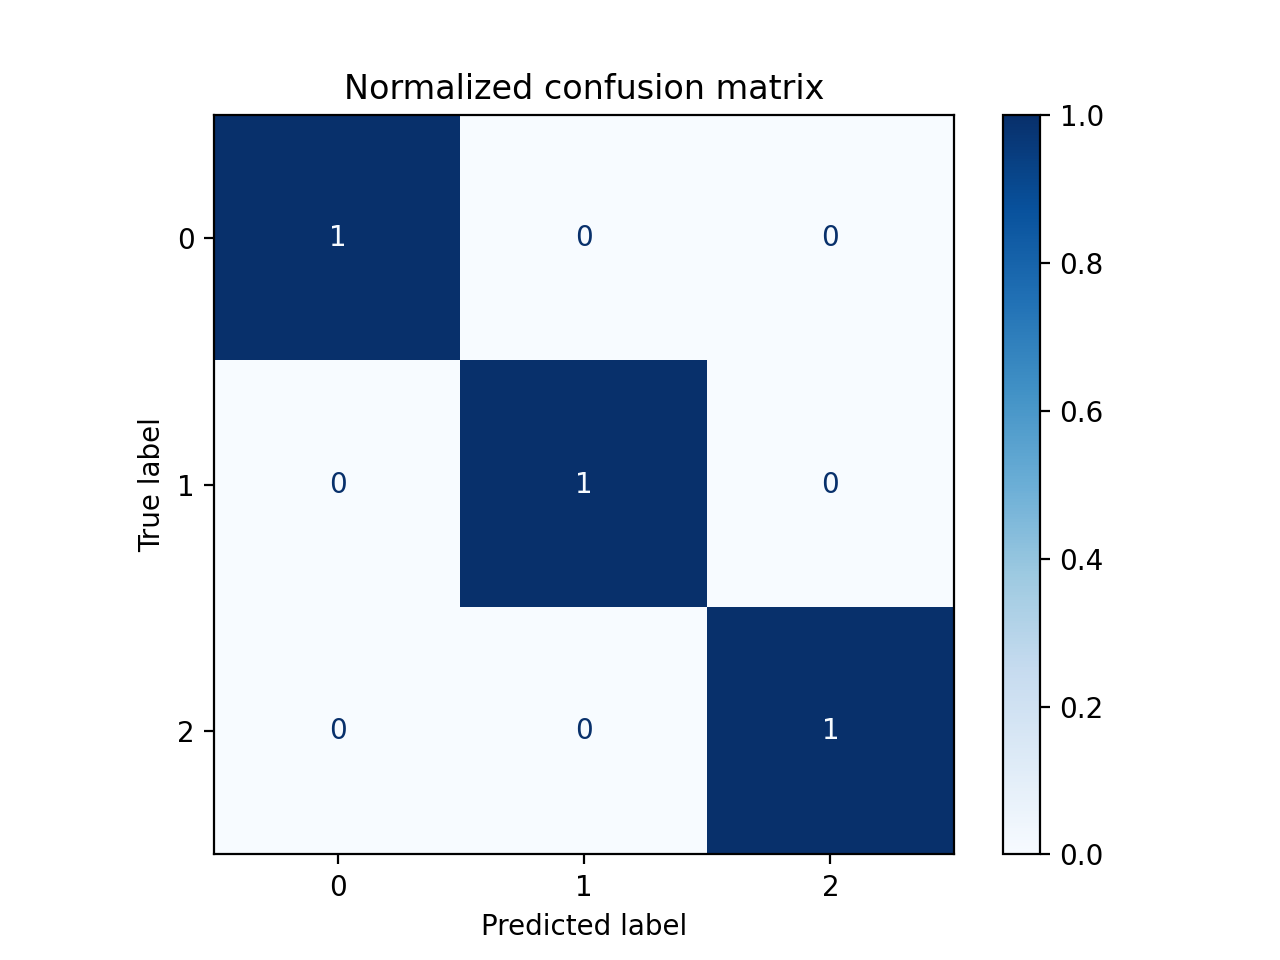

Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [32]:
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=xgboostModel, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

### Potential Reasons
##### (1) Ditribution Shift: DIfferent distrbution between training and testing datasets
##### (2) Noisy data: Too many outliners or useless features
##### (3) Overly Complex Model: The model is too complex.

### Solutions
##### (1) Ditribution Shift: Combine training and testing dataset and re-sample training and testing sets
##### (2) Noisy data: Filter outliners & Dataset compression
##### (3) Overly Complex Model: Hyperparameter tuning with grid search and regularization

### Quick Conclusion
I've design several experiments to exam the above 3 reasons. However, I found there is no distribution shift. For noisy data hypothesis, I use PCA compression but no improvement. However, I found outliner filter can provide a little performance improvement. The real factor that matters is the complexity of models. Thus, I use grid search for hyperparameter tuning and find out the best choice is full-feature (keep all 70 dimensions) and 5 max_depth for XGBoost classifier. I will present the best model in the final conclusion.

# Poential Reason 1: Distribution Shift
Here I combine the training and evaluating dataset and re-sample a new training and evaluating dataset. If the ditribution shift exists, the overfitting issue should disappear.

In [ ]:
data_sc: np.array = np.concatenate((train_data_sc, eval_data_sc), axis=0)
labels: np.array = np.concatenate((train_labels, eval_labels), axis=None)
X_test, X_train, y_test, y_train = train_test_split(data_sc, labels, test_size=0.5, random_state=42, shuffle=True)

However, the overfitting still exists. Thus, the distrbution shift should not be the main cause.

In [ ]:
xgboostModel = XGBClassifier(n_estimators=100, max_depth=20)
xgboostModel.fit(X_train, y_train)
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=xgboostModel, eval_data=X_test, eval_labels=y_test, train_data=X_train, train_labels=y_train)

# Potential Reason 2: Noisy data

I come up with 2 solution, PCA decomposition and outliner filter.

## (1) PCA Decomposition
## Search for Best Component Number for PCA Decomposition
The results is shown as below cells. In conclusion, I found no-compression yields the best accuracy and F1 score in testing dataset, which are 59.8% and 58.8%. Therefore, I will keep all features for the next stage.
### No Compression

In [43]:
param_pca = {
 'max_depth': [5, 10, 15, 20],
}

xgb_gridsearch(params=param_pca, file_name='gsearch_pca70', X_train=train_data_sc, y_train=train_labels)

gsearch_pca70 | Best Param: {'max_depth': 5}
gsearch_pca70 | Best Score: 0.5413649555424597


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1, param_grid={'max_depth': [5, 10, 15, 20]},
             scoring='f1_weighted')

gsearch_pca70 | Best Param: {'max_depth': 5}
gsearch_pca70 | Best Score: 0.5413649555424597
Test Acc: 0.598, Test F1: 0.589, Test Precision: 0.596, Test Recall: 0.598


<IPython.core.display.Javascript object>


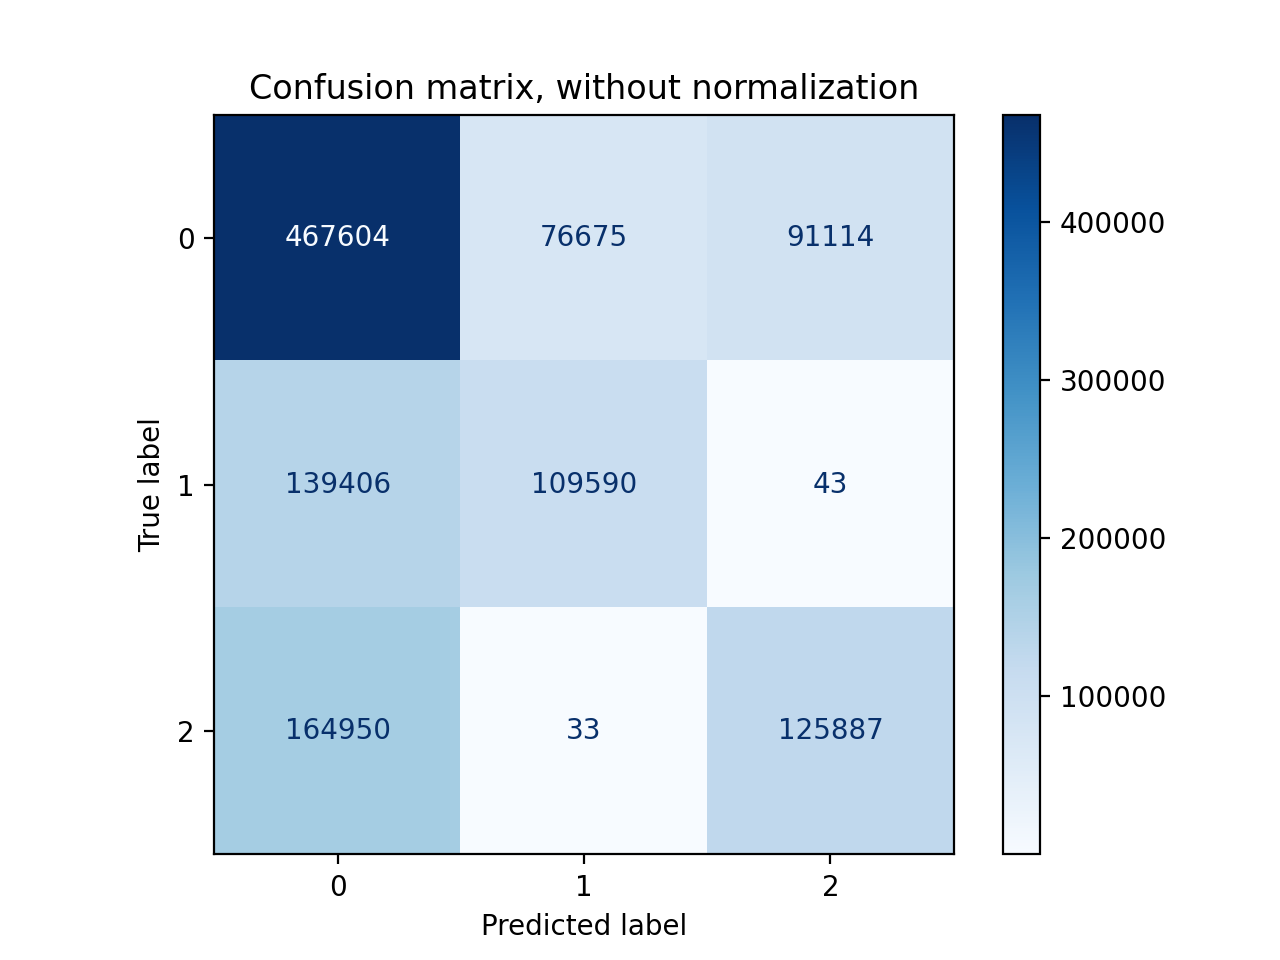

Confusion matrix, without normalization
[[467604  76675  91114]
 [139406 109590     43]
 [164950     33 125887]]


<IPython.core.display.Javascript object>


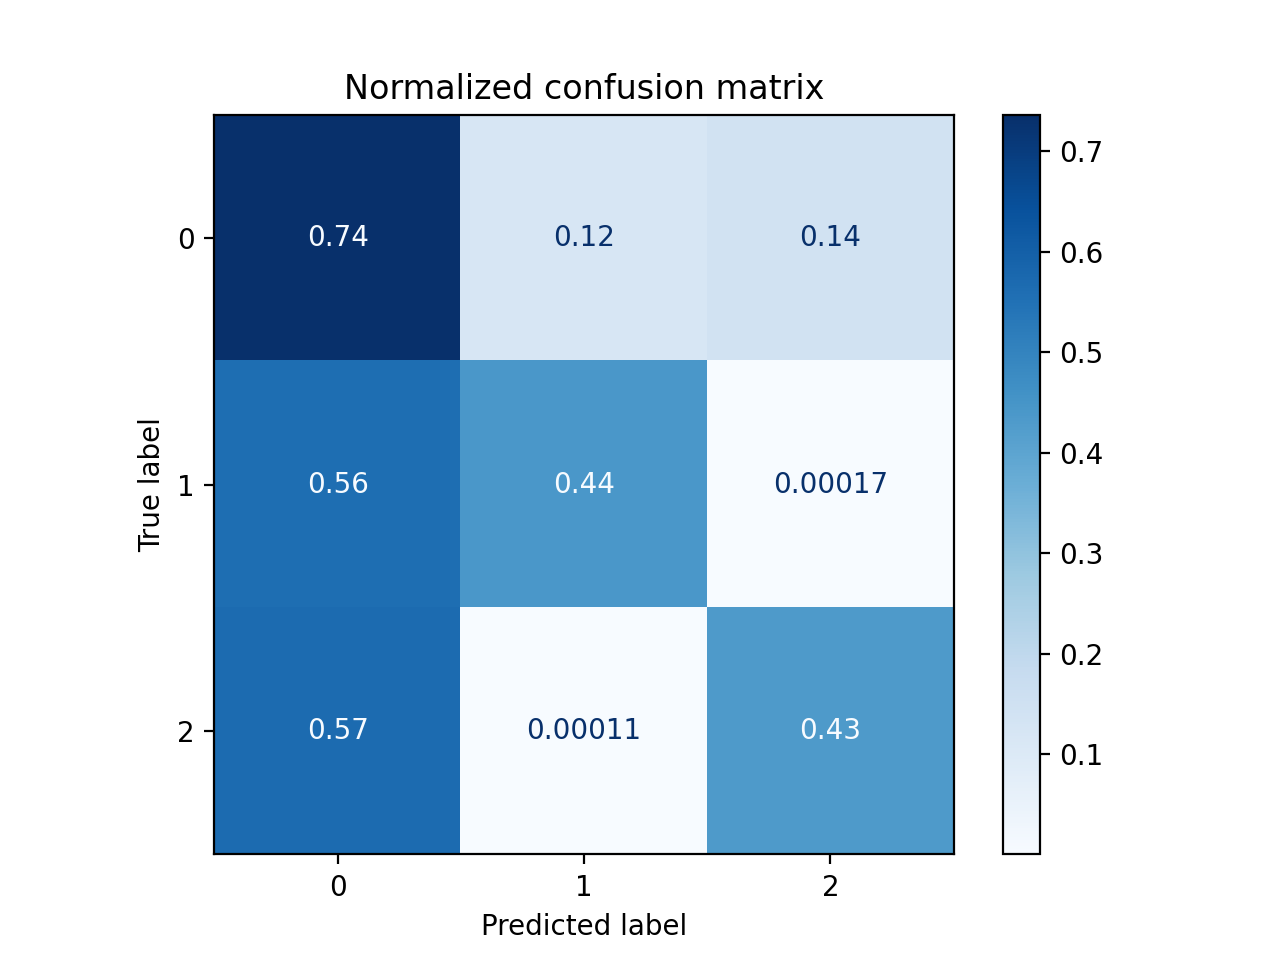

Normalized confusion matrix
[[7.36e-01 1.21e-01 1.43e-01]
 [5.60e-01 4.40e-01 1.73e-04]
 [5.67e-01 1.13e-04 4.33e-01]]
Train Acc: 0.631, Train F1: 0.626, Train Precision: 0.629, Train Recall: 0.631


<IPython.core.display.Javascript object>


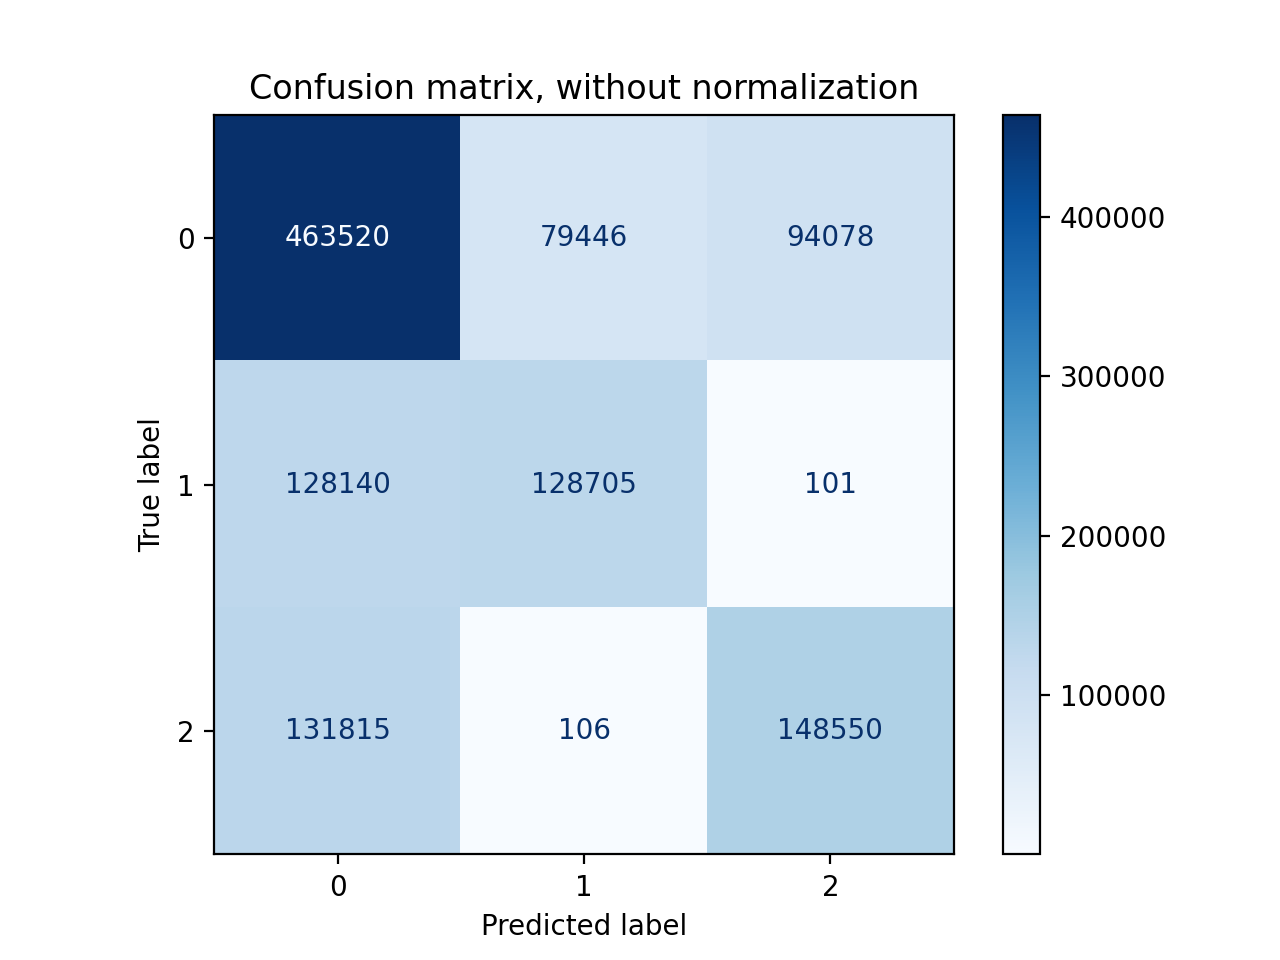

Confusion matrix, without normalization
[[463520  79446  94078]
 [128140 128705    101]
 [131815    106 148550]]


<IPython.core.display.Javascript object>


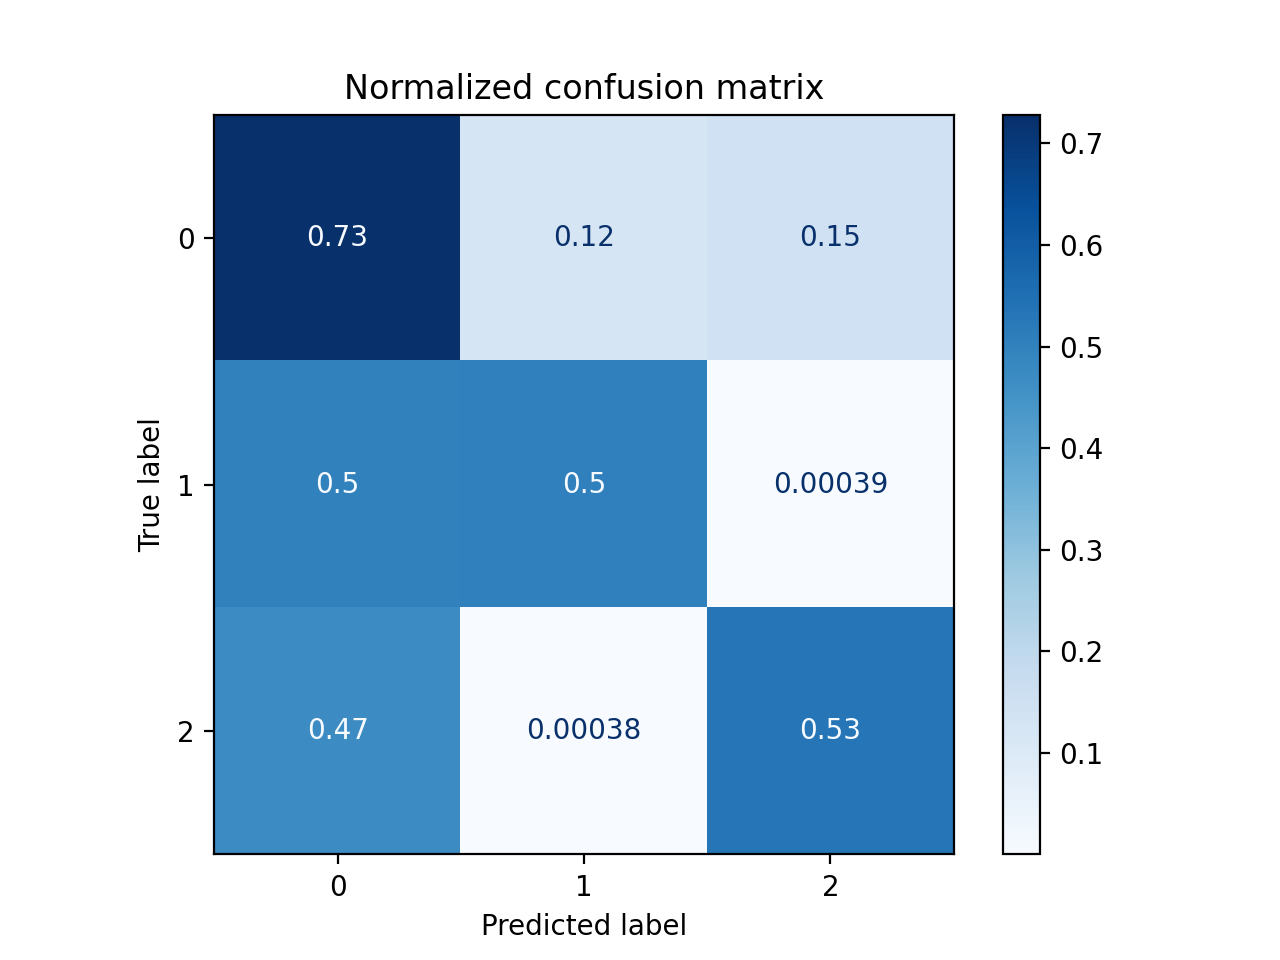

Normalized confusion matrix
[[7.28e-01 1.25e-01 1.48e-01]
 [4.99e-01 5.01e-01 3.93e-04]
 [4.70e-01 3.78e-04 5.30e-01]]


In [100]:
file_name='gsearch_pca70'
with open(f'{file_name}.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(f"{file_name} | CV Results: {grid_search.cv_results_}")
print(f"{file_name} | Best Param: {grid_search.best_params_}")
print(f"{file_name} | Best Score: {grid_search.best_score_}")
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

### Compress the dataset into 50 dimensions with PCA

In [106]:
X_train_pca50, X_test_pca50 = pca_trans(n_components=50, X_train=train_data_sc, X_test=eval_data_sc)
xgb_gridsearch(params=param_pca, file_name='gsearch_pca50', X_train=X_train_pca50, y_train=train_labels)

(1174461, 50)
[[ 1.77 -2.45  2.28 ...  0.08  0.62 -0.35]
 [ 2.17 -0.4   3.4  ... -0.13  0.16  0.58]
 [ 1.59  0.72  2.34 ... -0.09  0.39  0.09]
 ...
 [ 3.05  3.25 -1.09 ... -0.08 -0.32 -0.54]
 [ 2.59  4.3  -0.85 ... -0.33  0.5  -0.04]
 [ 0.81  2.07 -2.4  ... -0.15 -0.25  1.58]]
Value Range: [-49.856535772845966:658.2810567409966]


gsearch_pca50 | Best Param: {'max_depth': 5}
gsearch_pca50 | Best Score: 0.5683758421056313
Test Acc: 0.578, Test F1: 0.571, Test Precision: 0.574, Test Recall: 0.578


<IPython.core.display.Javascript object>


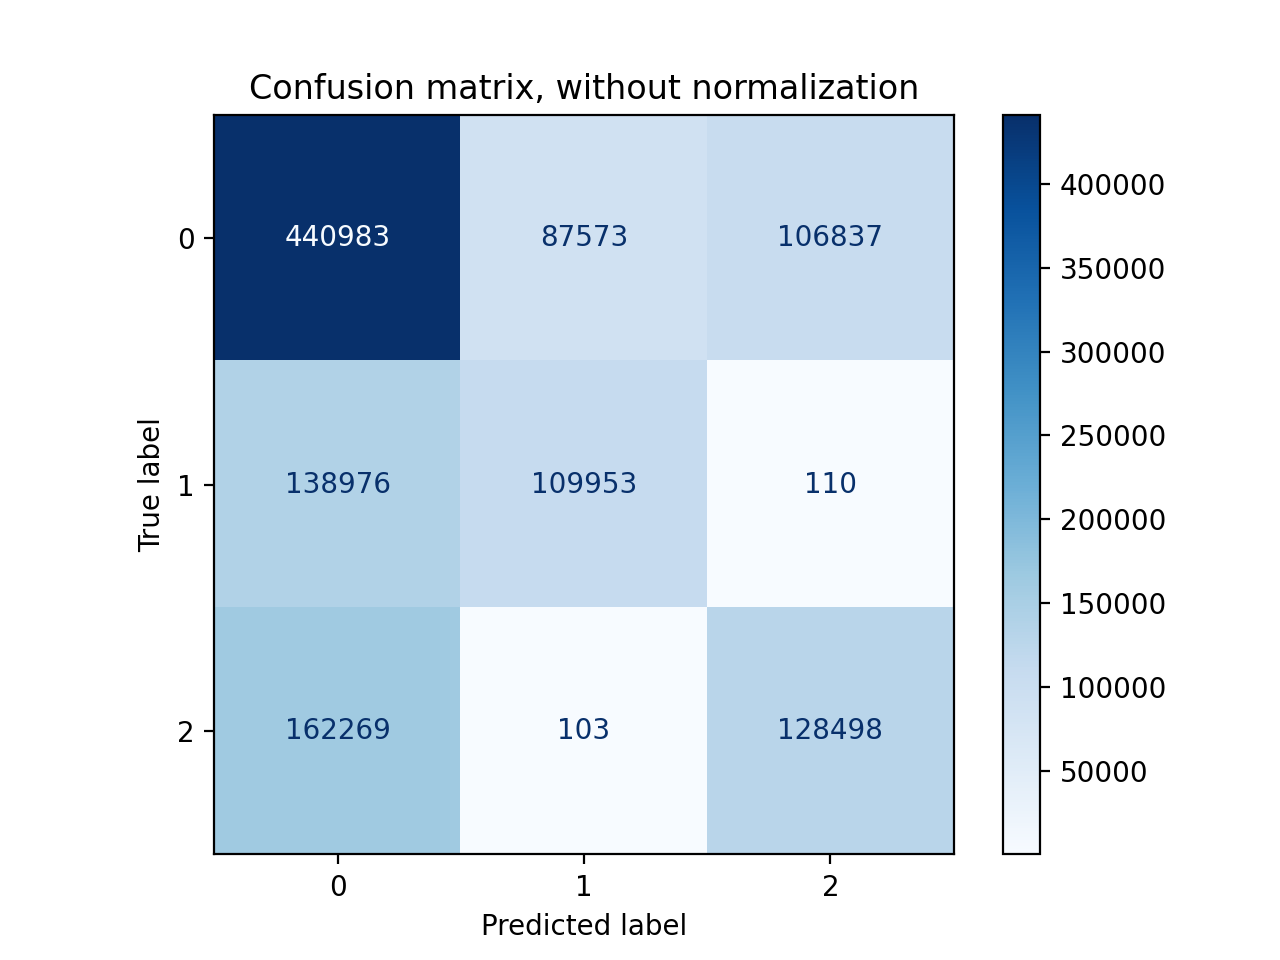

Confusion matrix, without normalization
[[440983  87573 106837]
 [138976 109953    110]
 [162269    103 128498]]


<IPython.core.display.Javascript object>


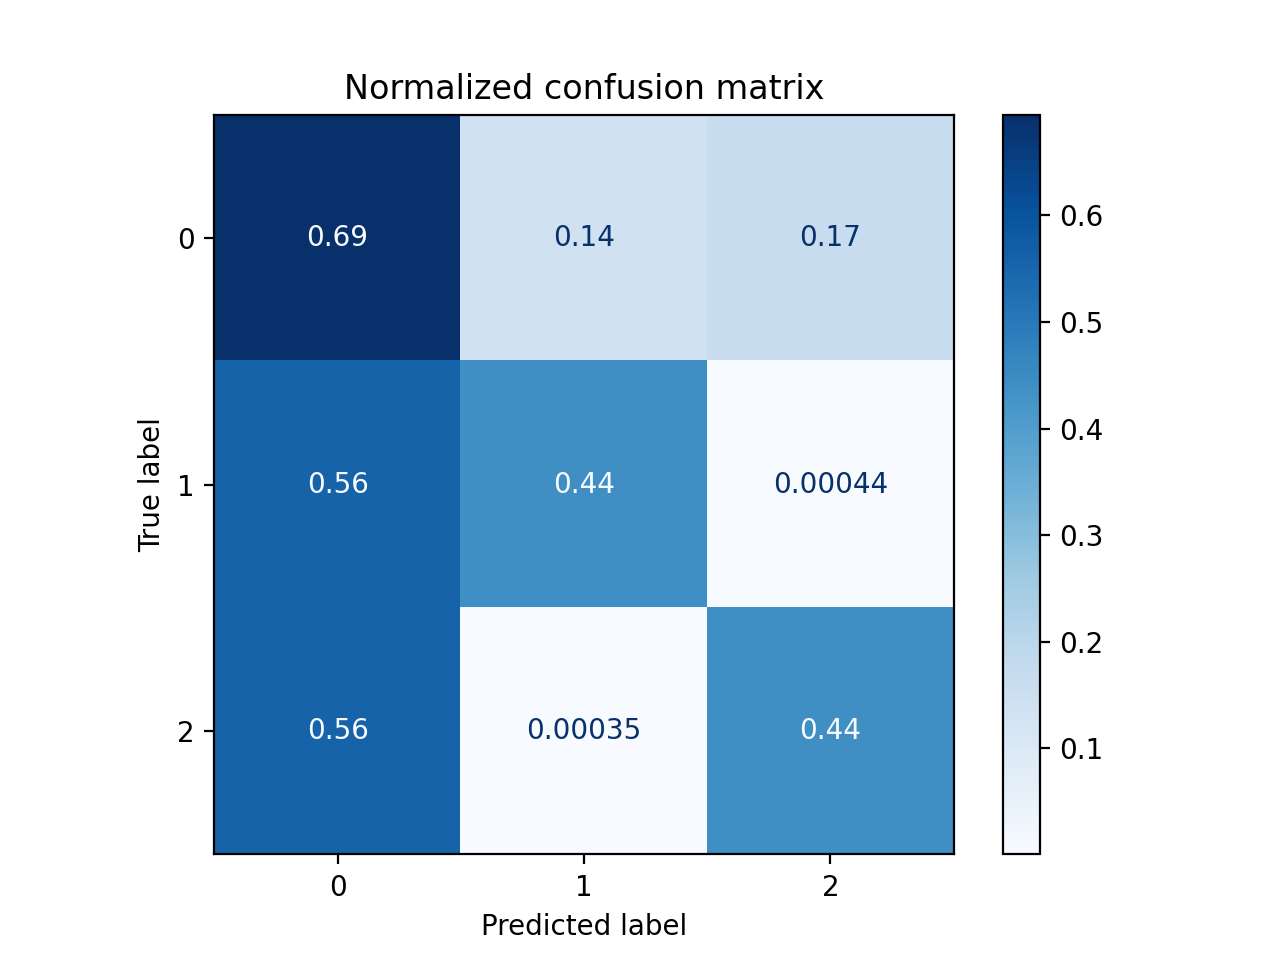

Normalized confusion matrix
[[6.94e-01 1.38e-01 1.68e-01]
 [5.58e-01 4.42e-01 4.42e-04]
 [5.58e-01 3.54e-04 4.42e-01]]
Train Acc: 0.599, Train F1: 0.592, Train Precision: 0.596, Train Recall: 0.599


/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


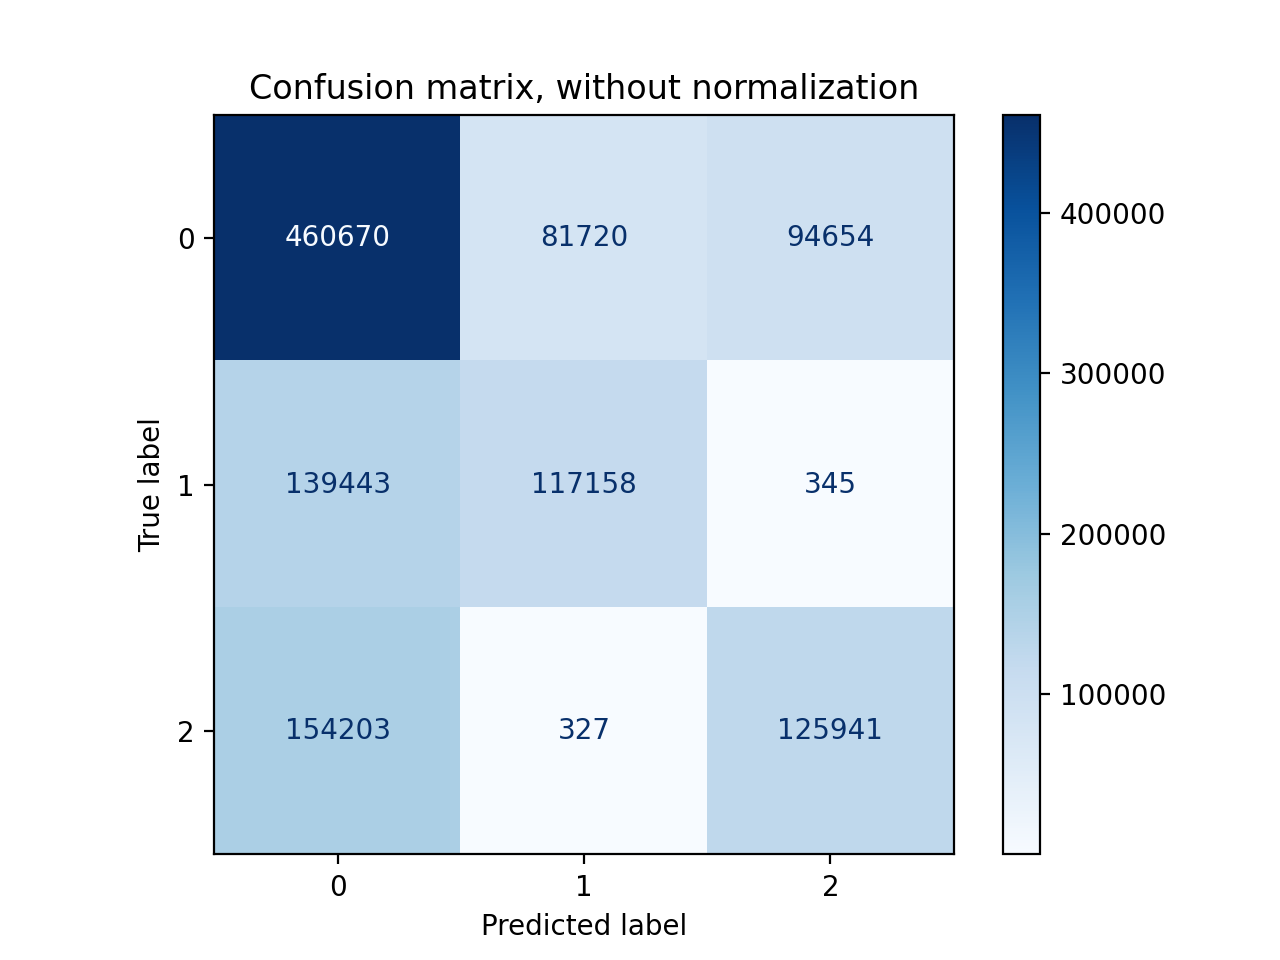

Confusion matrix, without normalization
[[460670  81720  94654]
 [139443 117158    345]
 [154203    327 125941]]


<IPython.core.display.Javascript object>


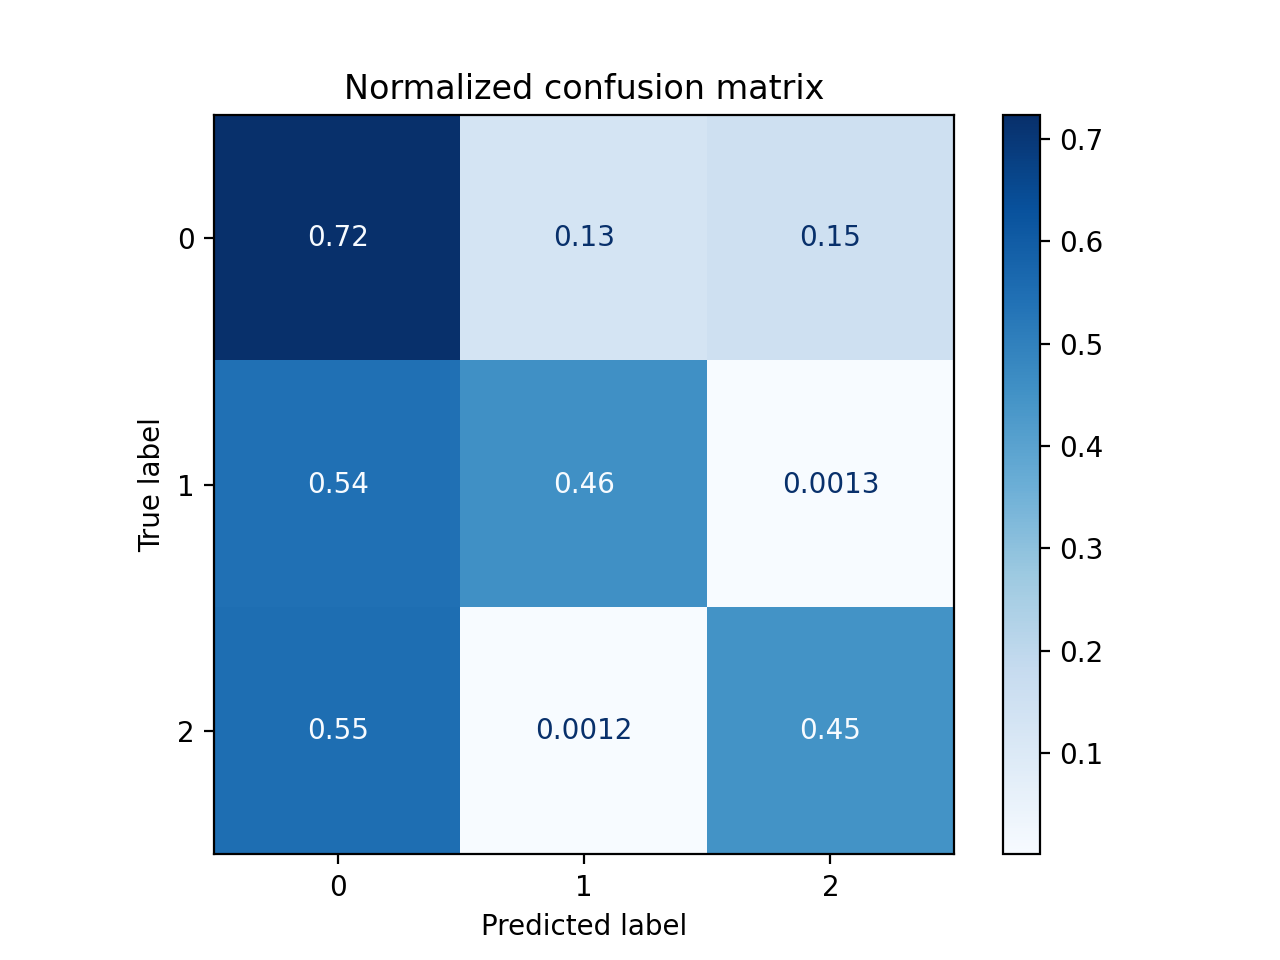

Normalized confusion matrix
[[0.72 0.13 0.15]
 [0.54 0.46 0.  ]
 [0.55 0.   0.45]]


In [107]:
file_name='gsearch_pca50'
with open(f'{file_name}.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(f"{file_name} | CV Results: {grid_search.cv_results_}")
print(f"{file_name} | Best Param: {grid_search.best_params_}")
print(f"{file_name} | Best Score: {grid_search.best_score_}")
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=X_test_pca50, eval_labels=eval_labels, train_data=X_train_pca50, train_labels=train_labels)

### Compress the dataset into 20 dimensions with PCA

In [104]:
X_train_pca20, X_test_pca20 = pca_trans(n_components=20, X_train=train_data_sc, X_test=eval_data_sc)
xgb_gridsearch(params=param_pca, file_name='gsearch_pca20', X_train=X_train_pca20, y_train=train_labels)

(1174461, 20)
[[ 1.77 -2.45  2.28 ... -0.62 -0.43  0.4 ]
 [ 2.17 -0.4   3.4  ... -0.78 -1.63  0.4 ]
 [ 1.59  0.72  2.34 ... -0.57 -2.88  0.69]
 ...
 [ 3.05  3.25 -1.09 ...  1.77  0.85  0.67]
 [ 2.59  4.3  -0.85 ...  1.57  0.5  -0.37]
 [ 0.81  2.07 -2.4  ...  2.19 -0.72  0.11]]
Value Range: [-41.497365135337176:217.80770891747838]


gsearch_pca20 | Best Param: {'max_depth': 10}
gsearch_pca20 | Best Score: 0.5618430596329118
Test Acc: 0.560, Test F1: 0.549, Test Precision: 0.554, Test Recall: 0.560


<IPython.core.display.Javascript object>


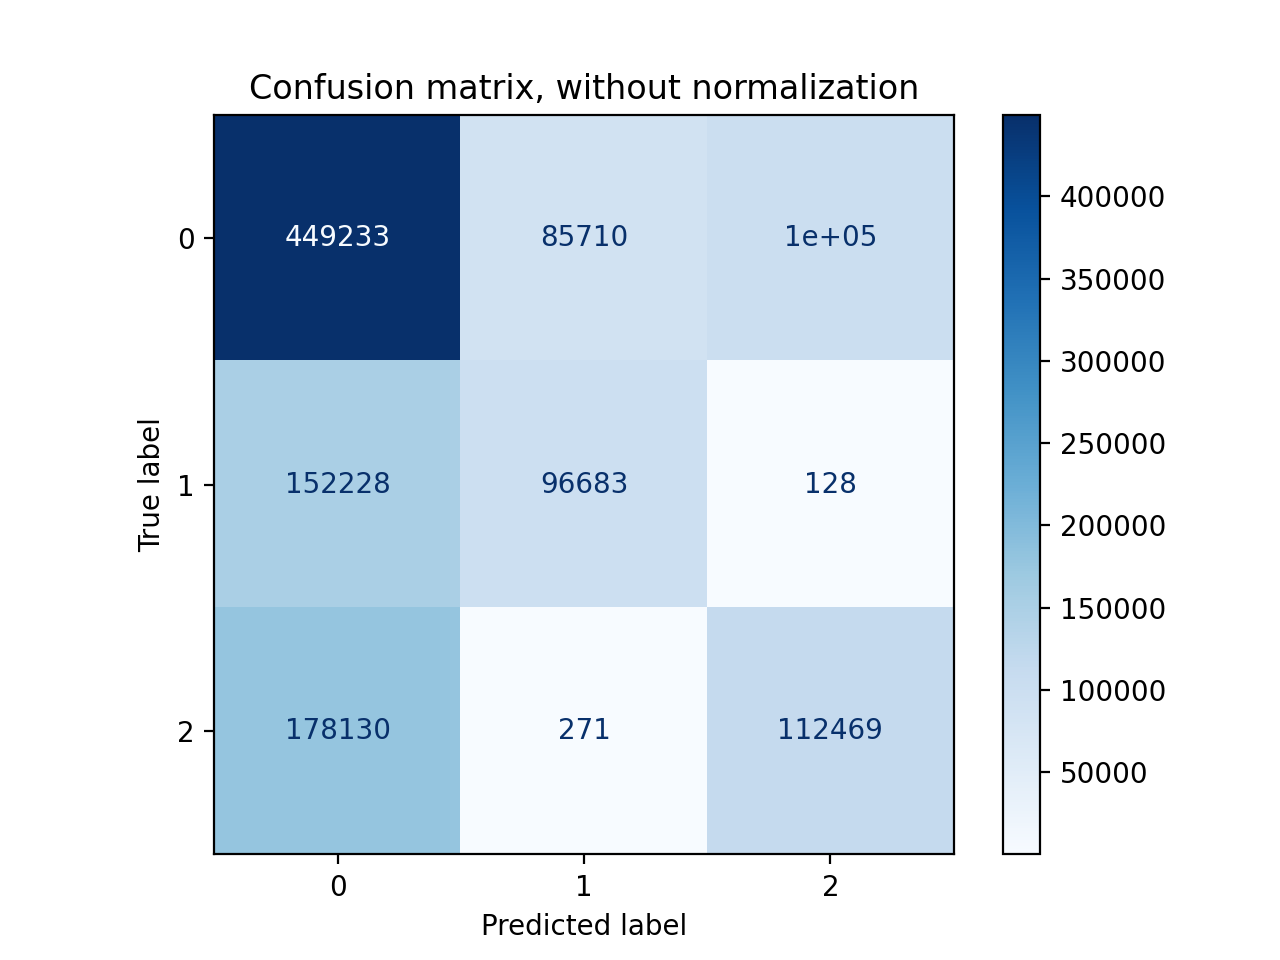

Confusion matrix, without normalization
[[449233  85710 100450]
 [152228  96683    128]
 [178130    271 112469]]


<IPython.core.display.Javascript object>


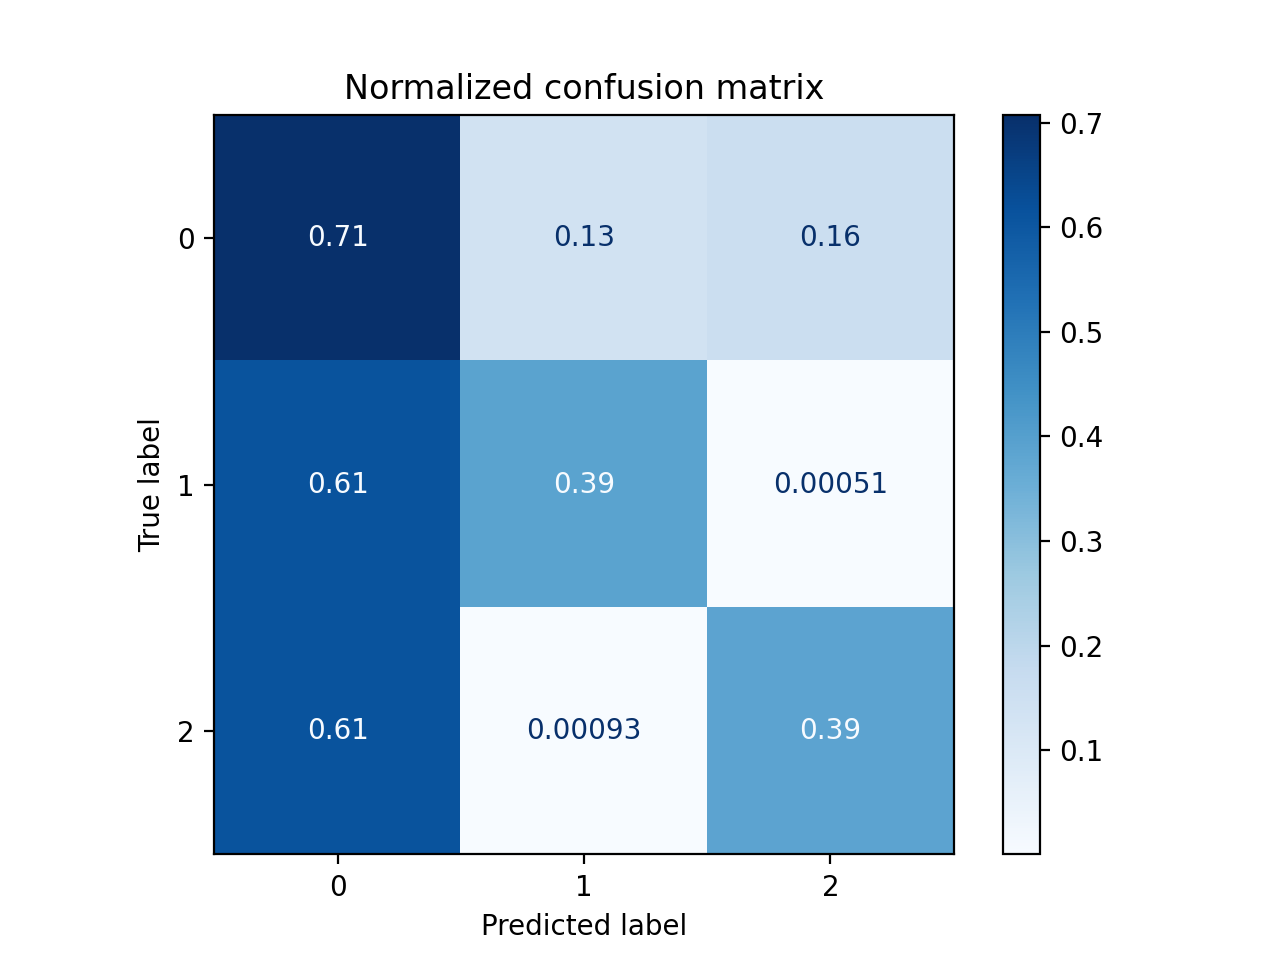

Normalized confusion matrix
[[7.07e-01 1.35e-01 1.58e-01]
 [6.11e-01 3.88e-01 5.14e-04]
 [6.12e-01 9.32e-04 3.87e-01]]
Train Acc: 0.619, Train F1: 0.610, Train Precision: 0.617, Train Recall: 0.619


<IPython.core.display.Javascript object>


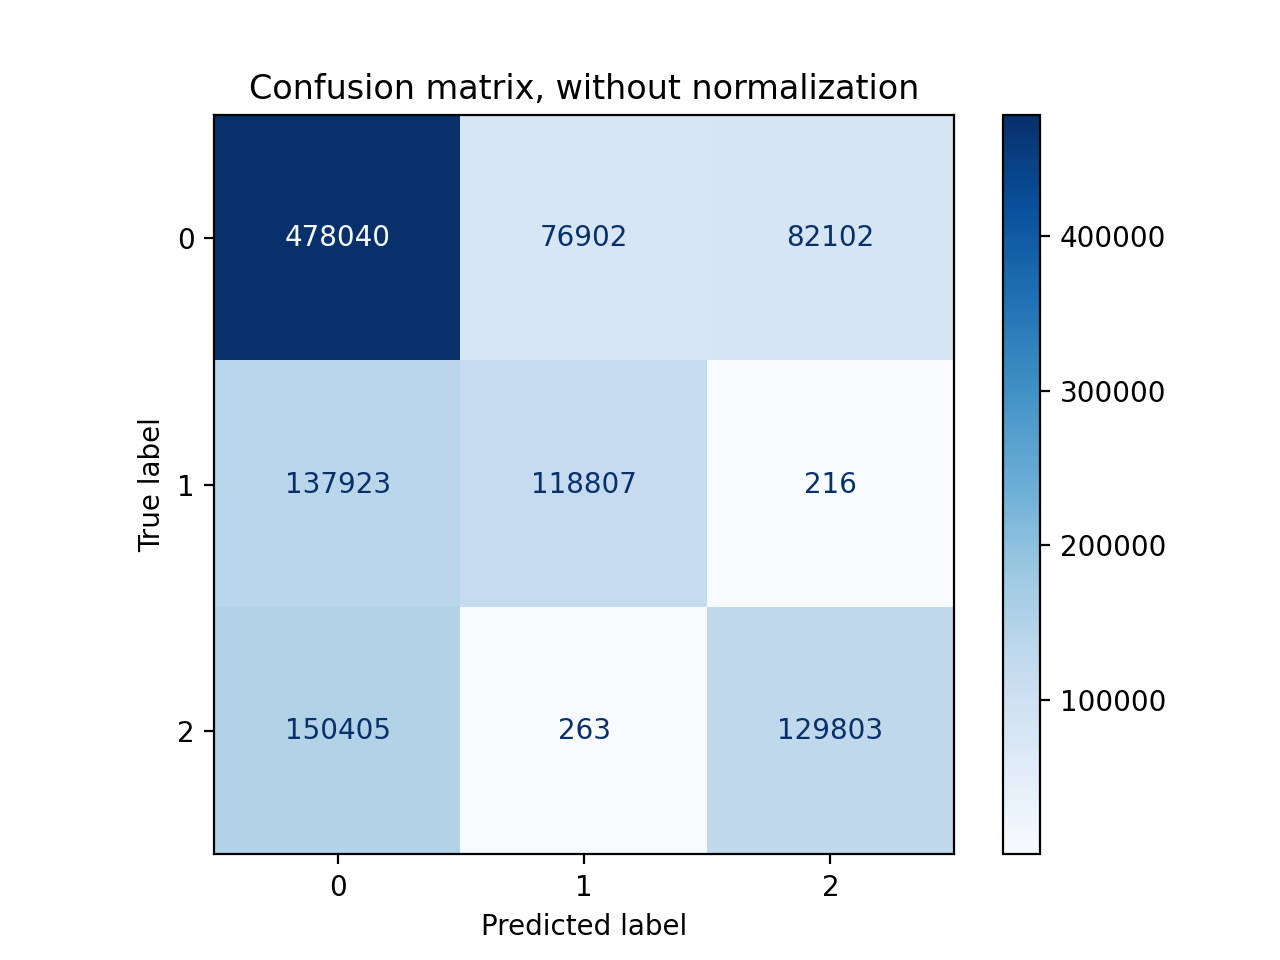

Confusion matrix, without normalization
[[478040  76902  82102]
 [137923 118807    216]
 [150405    263 129803]]


<IPython.core.display.Javascript object>


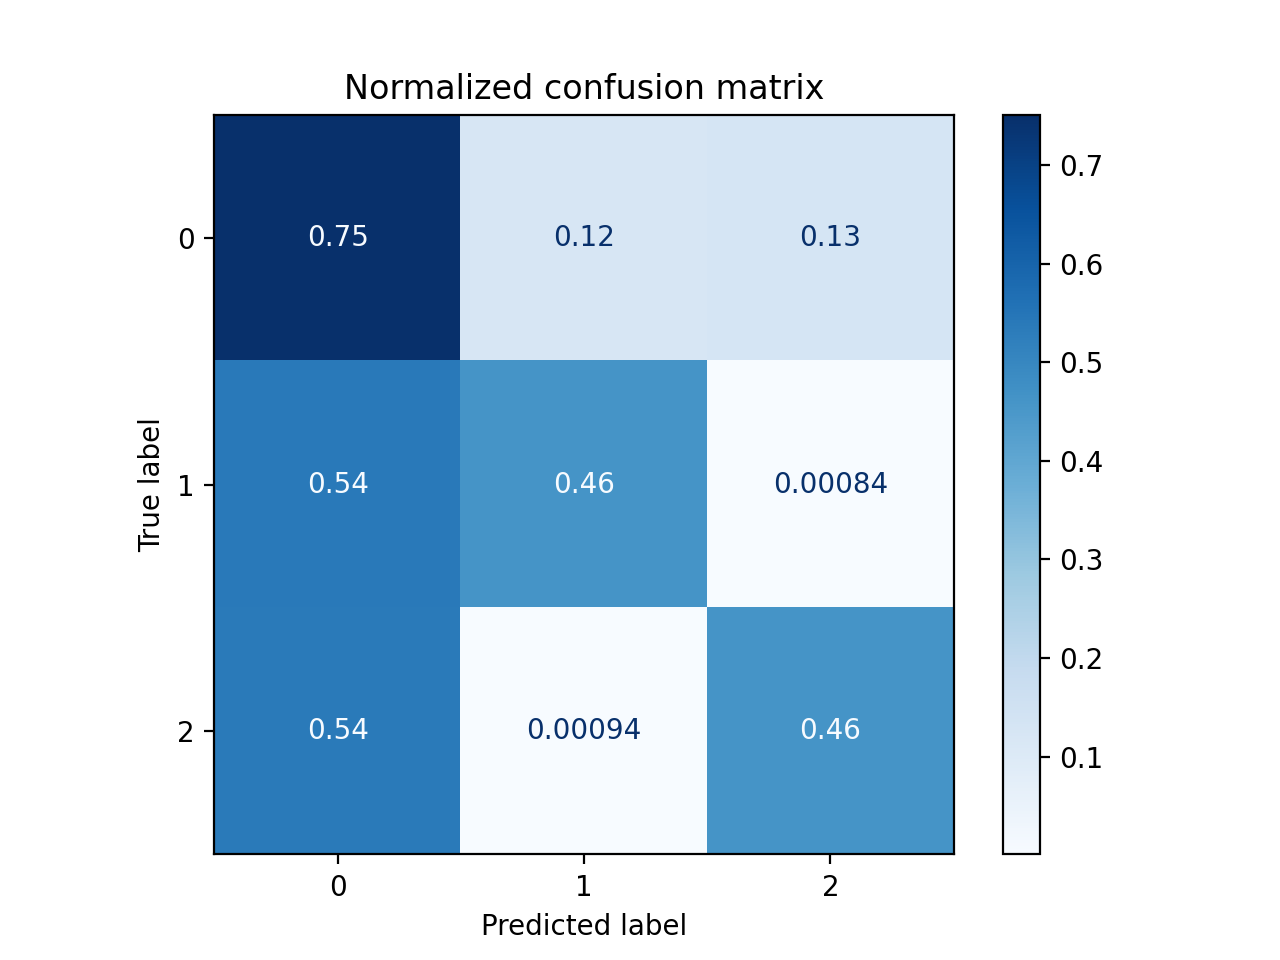

Normalized confusion matrix
[[0.75 0.12 0.13]
 [0.54 0.46 0.  ]
 [0.54 0.   0.46]]


In [105]:
file_name='gsearch_pca20'
with open(f'{file_name}.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(f"{file_name} | CV Results: {grid_search.cv_results_}")
print(f"{file_name} | Best Param: {grid_search.best_params_}")
print(f"{file_name} | Best Score: {grid_search.best_score_}")
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=X_test_pca20, eval_labels=eval_labels, train_data=X_train_pca20, train_labels=train_labels)

### Compress the dataset into 10 dimensions with PCA

In [48]:
X_train_pca10, X_test_pca10 = pca_trans(n_components=10, X_train=train_data_sc, X_test=eval_data_sc)
xgb_gridsearch(params=param_pca, file_name='gsearch_pca10', X_train=X_train_pca10, y_train=train_labels)

(1174461, 10)
[[ 1.77 -2.45  2.28 ...  0.6   1.76  1.57]
 [ 2.17 -0.4   3.4  ... -0.02  1.08  0.48]
 [ 1.59  0.72  2.34 ...  0.08 -1.21  0.14]
 ...
 [ 3.05  3.25 -1.09 ...  0.95  0.98  0.1 ]
 [ 2.59  4.3  -0.85 ... -1.88  1.31 -0.48]
 [ 0.81  2.07 -2.4  ... -1.53 -1.9   2.32]]
Value Range: [-18.448204764796845:208.93814057705578]
gsearch_pca10 | Best Param: {'max_depth': 10}
gsearch_pca10 | Best Score: 0.5509259180256822


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1, param_grid={'max_depth': [5, 10, 15, 20]},
             scoring='f1_weighted')

gsearch_pca10 | Best Param: {'max_depth': 10}
gsearch_pca10 | Best Score: 0.5509259180256822
Test Acc: 0.552, Test F1: 0.544, Test Precision: 0.546, Test Recall: 0.552


<IPython.core.display.Javascript object>


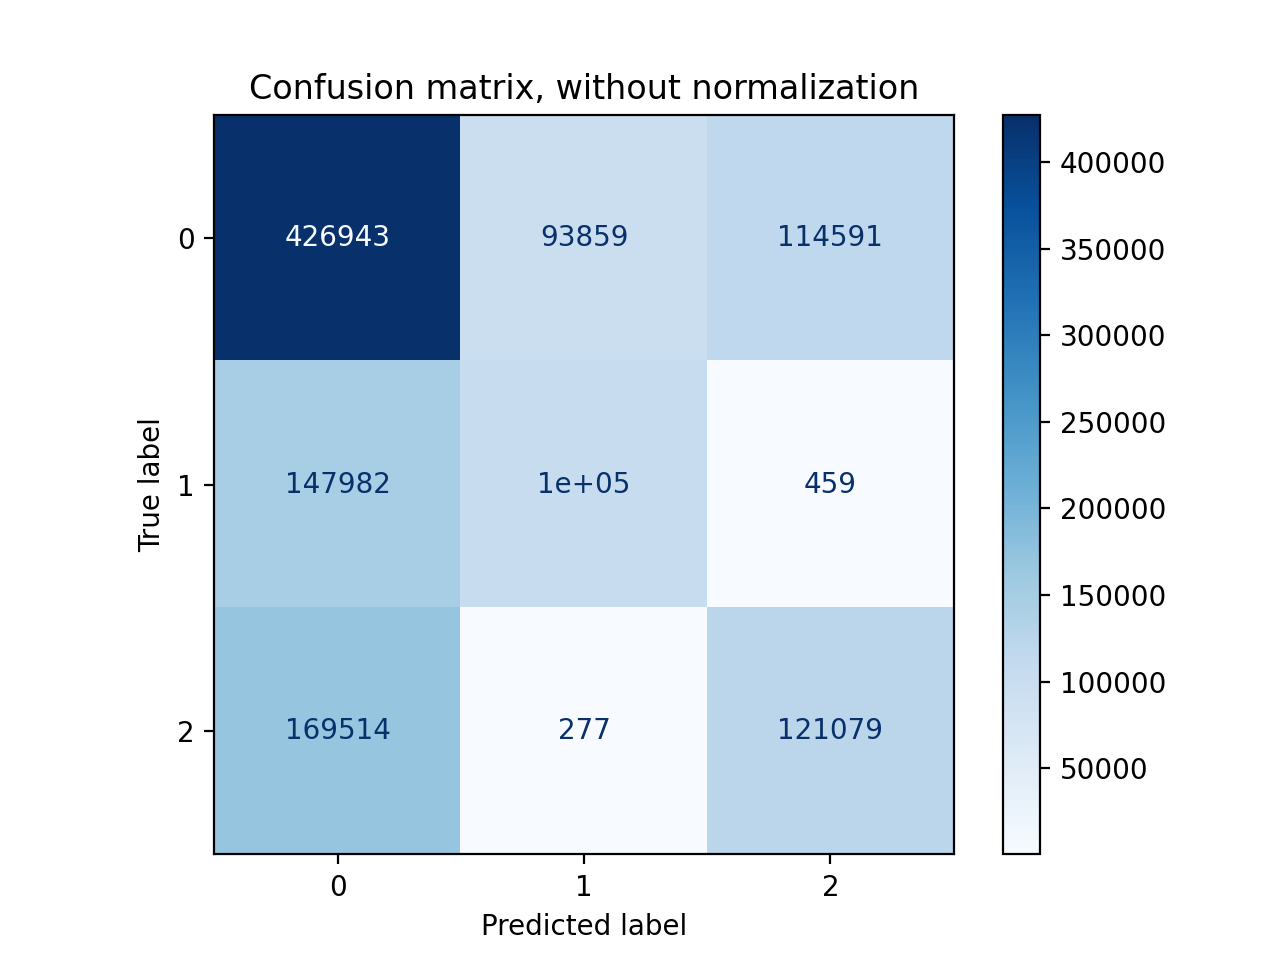

Confusion matrix, without normalization
[[426943  93859 114591]
 [147982 100598    459]
 [169514    277 121079]]


<IPython.core.display.Javascript object>


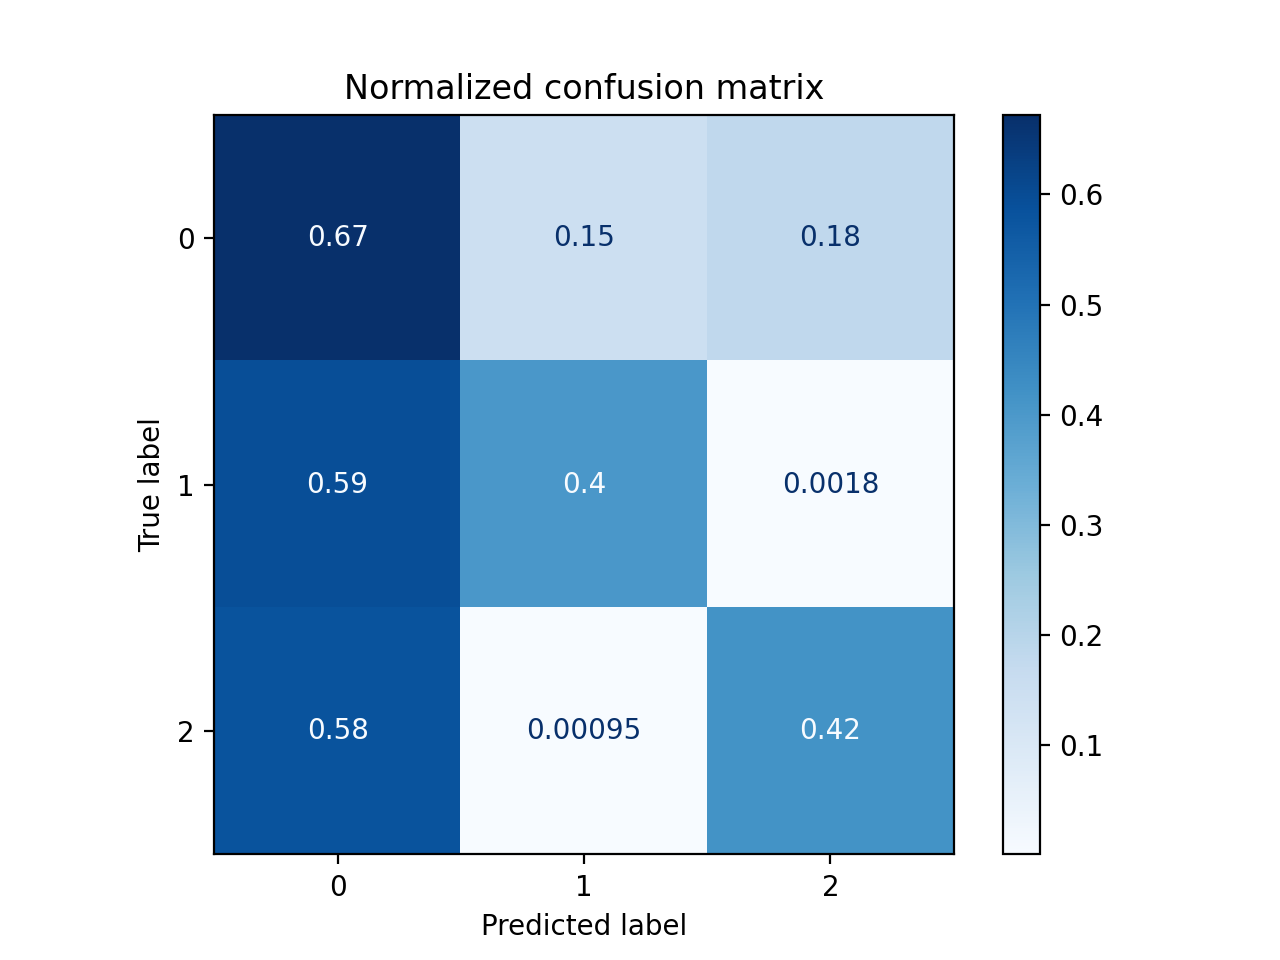

Normalized confusion matrix
[[0.67 0.15 0.18]
 [0.59 0.4  0.  ]
 [0.58 0.   0.42]]
Train Acc: 0.615, Train F1: 0.606, Train Precision: 0.613, Train Recall: 0.615


<IPython.core.display.Javascript object>


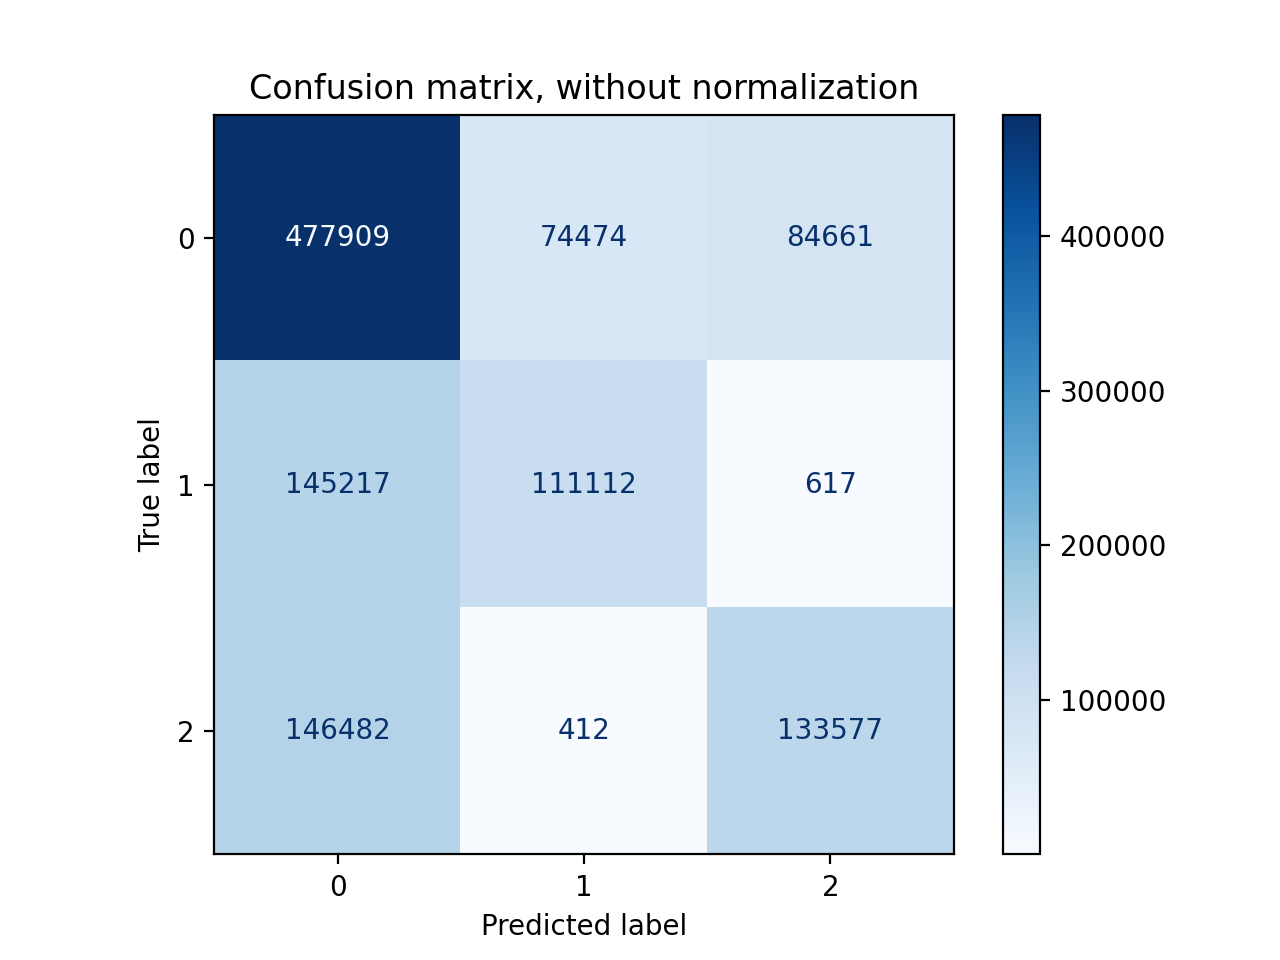

Confusion matrix, without normalization
[[477909  74474  84661]
 [145217 111112    617]
 [146482    412 133577]]


<IPython.core.display.Javascript object>


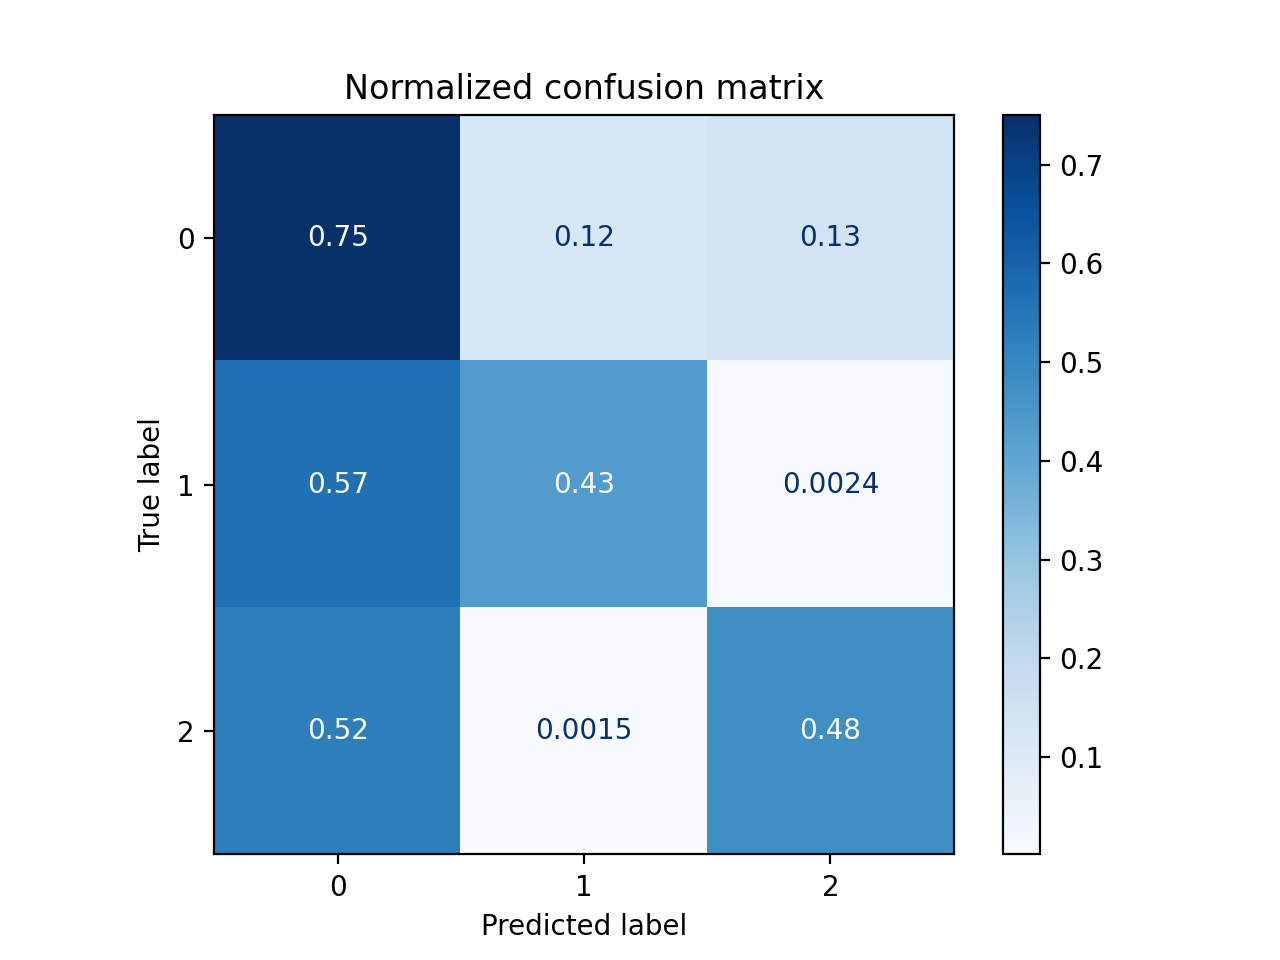

Normalized confusion matrix
[[0.75 0.12 0.13]
 [0.57 0.43 0.  ]
 [0.52 0.   0.48]]


In [102]:
file_name='gsearch_pca10'
with open(f'{file_name}.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(f"{file_name} | CV Results: {grid_search.cv_results_}")
print(f"{file_name} | Best Param: {grid_search.best_params_}")
print(f"{file_name} | Best Score: {grid_search.best_score_}")
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=X_test_pca10, eval_labels=eval_labels, train_data=X_train_pca10, train_labels=train_labels)

# Check Compressed Dataset with More Complex Model
Check the 10-dimensions dataset with 20 max_depth XGBoost forest. However, I found it would overfitting severely.

In [10]:
xgboostModel = XGBClassifier(n_estimators=100, max_depth=20)
xgboostModel.fit(X_train_pca10, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Importance Analysis
As we can see, PCA only keep important dimensions

<IPython.core.display.Javascript object>


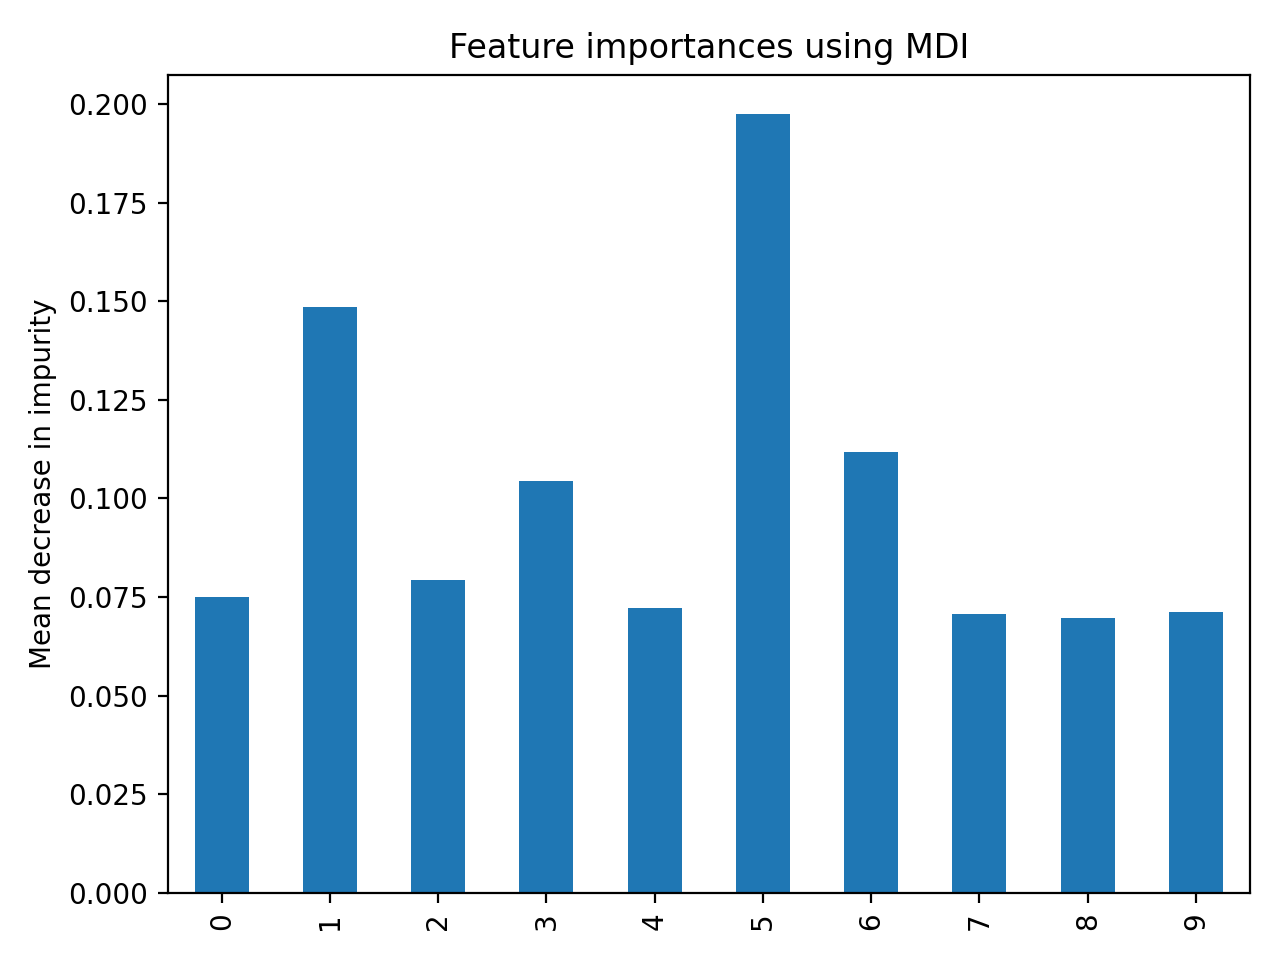

In [11]:
importances = xgboostModel.feature_importances_
plot_importance(importances=importances)

## Overfitting
Still overfitting on 10-dimension dataset. The model get 100% accuracy and F1 score in training dataset but 54% in testing dataset.

Test Acc: 0.5472125462221624, Test F1: 0.5405697281732865


<IPython.core.display.Javascript object>


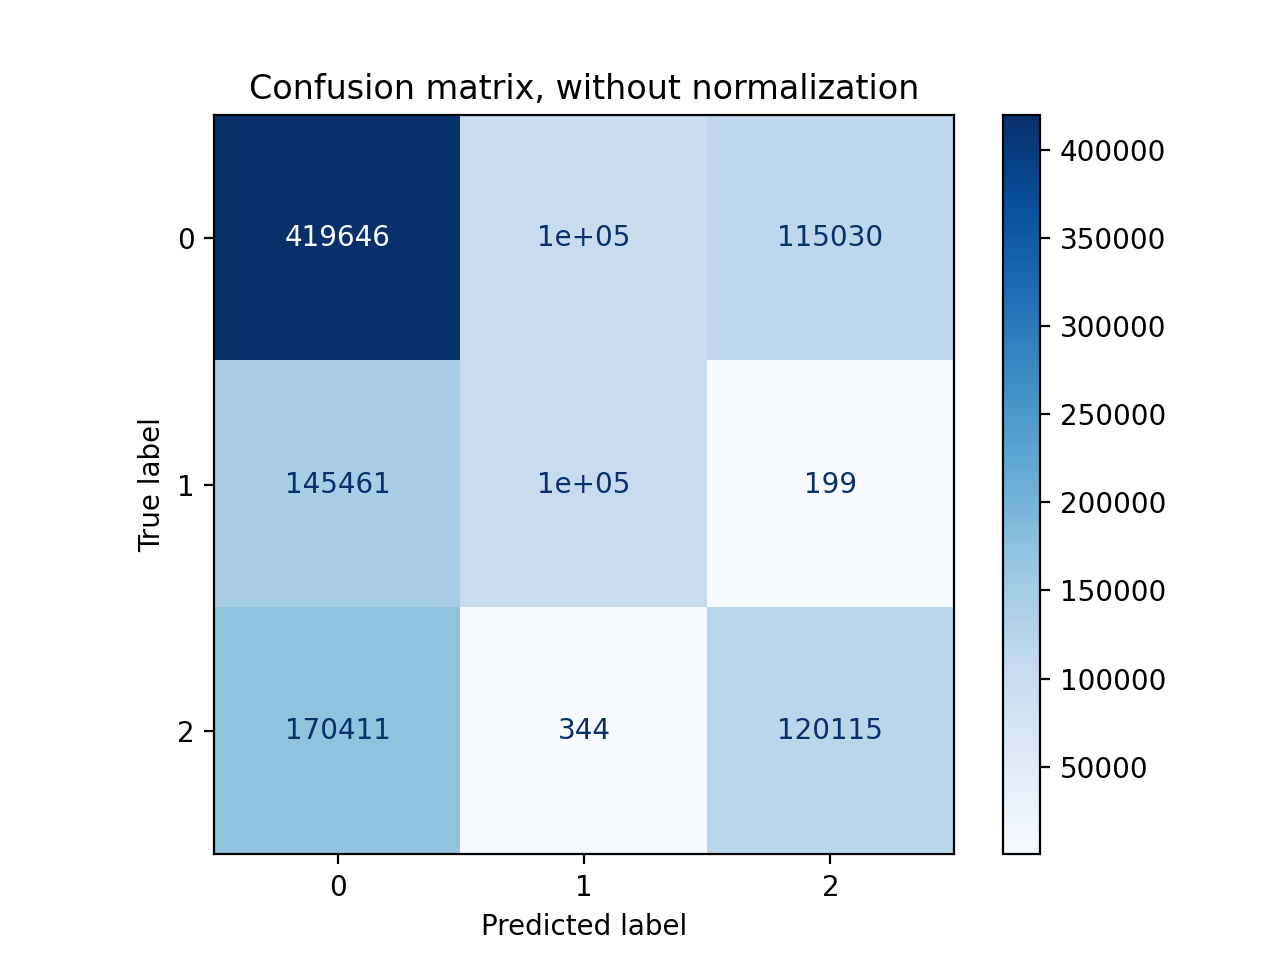

Confusion matrix, without normalization
[[419646 100717 115030]
 [145461 103379    199]
 [170411    344 120115]]


<IPython.core.display.Javascript object>


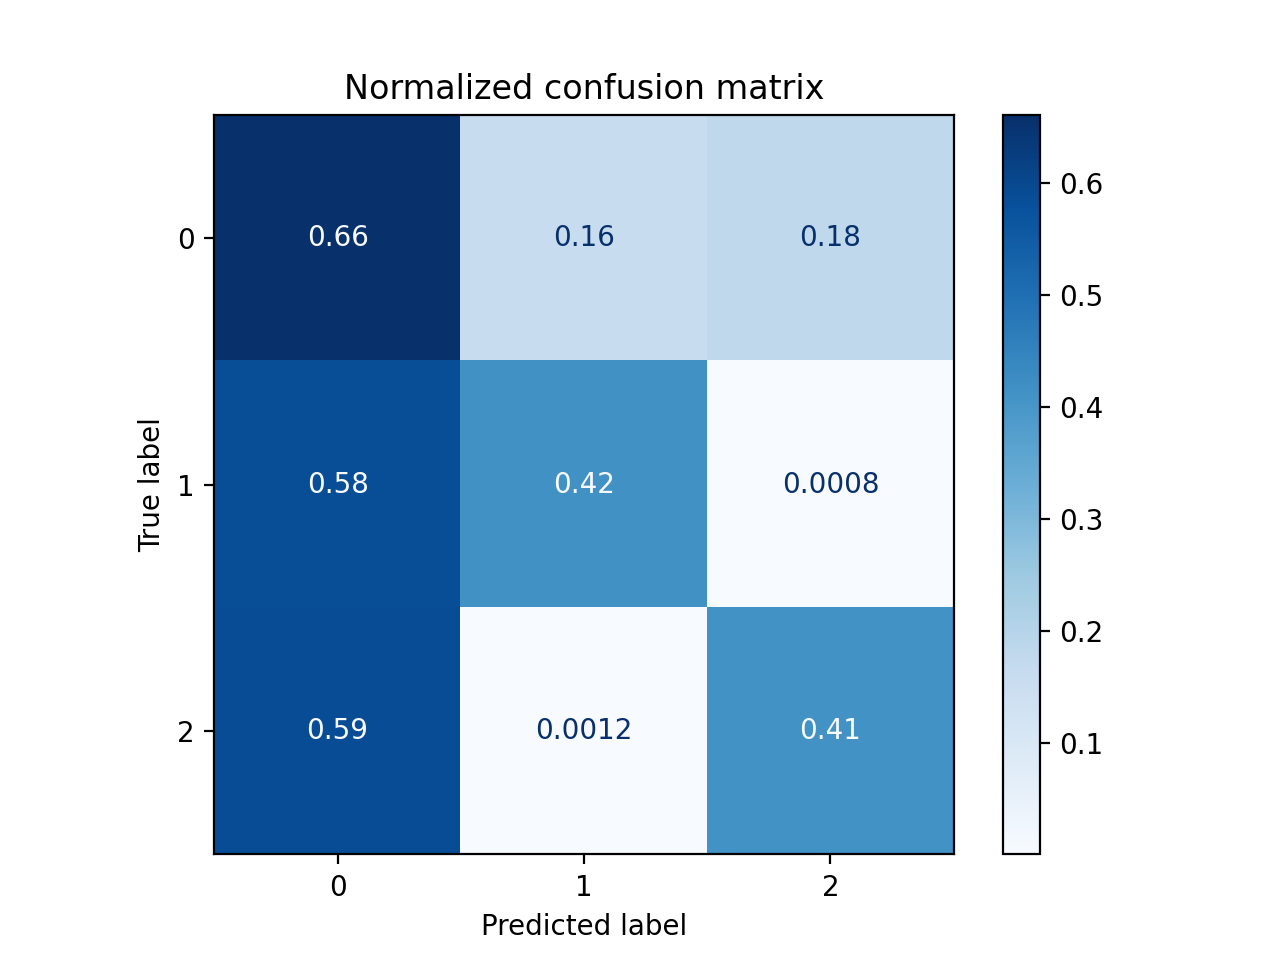

Normalized confusion matrix
[[0.66 0.16 0.18]
 [0.58 0.42 0.  ]
 [0.59 0.   0.41]]
Train Acc: 0.9999684961867614, Train F1: 0.9999684960161487


<IPython.core.display.Javascript object>


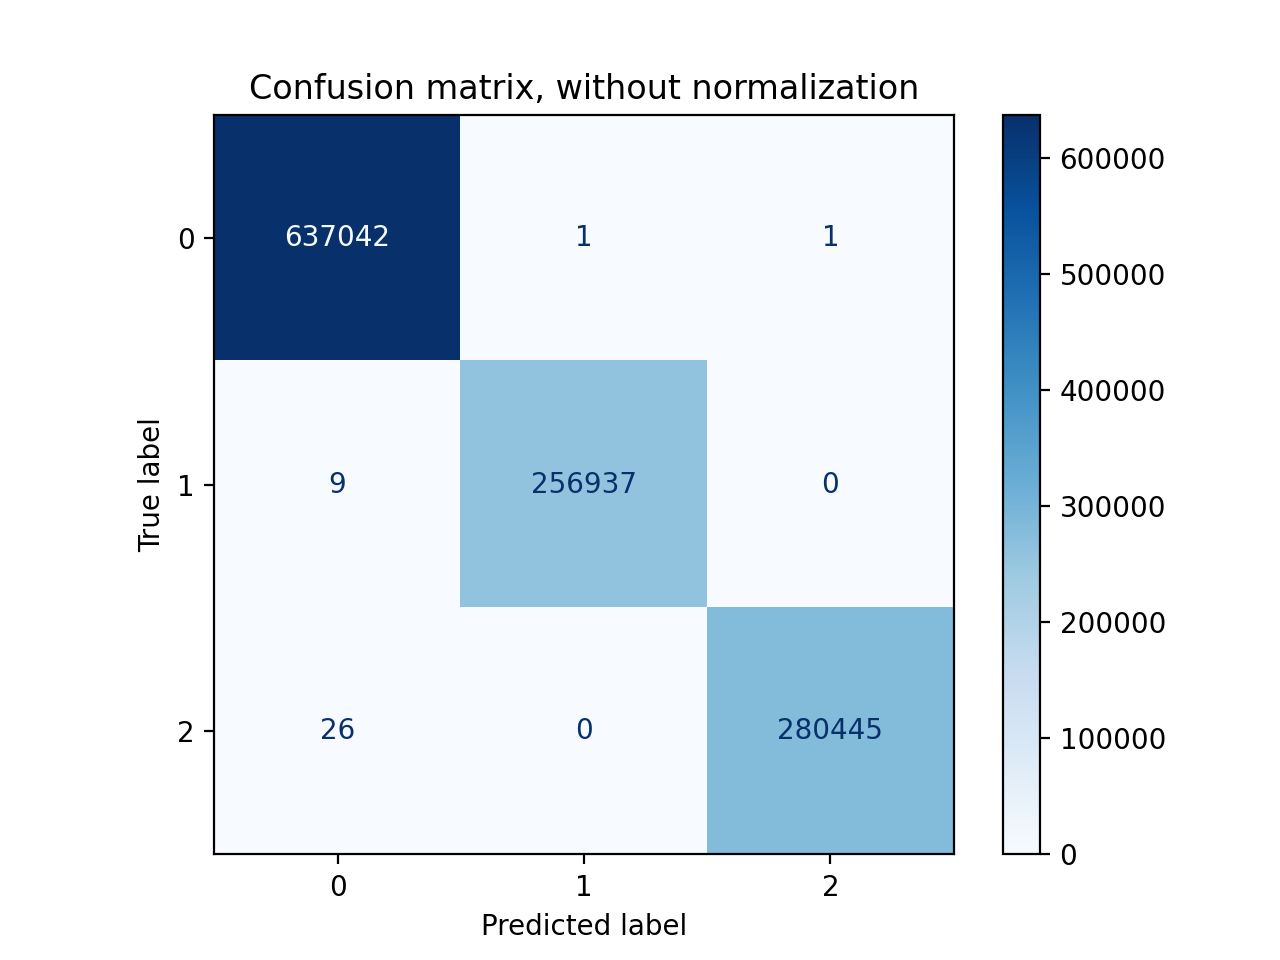

Confusion matrix, without normalization
[[637042      1      1]
 [     9 256937      0]
 [    26      0 280445]]


<IPython.core.display.Javascript object>


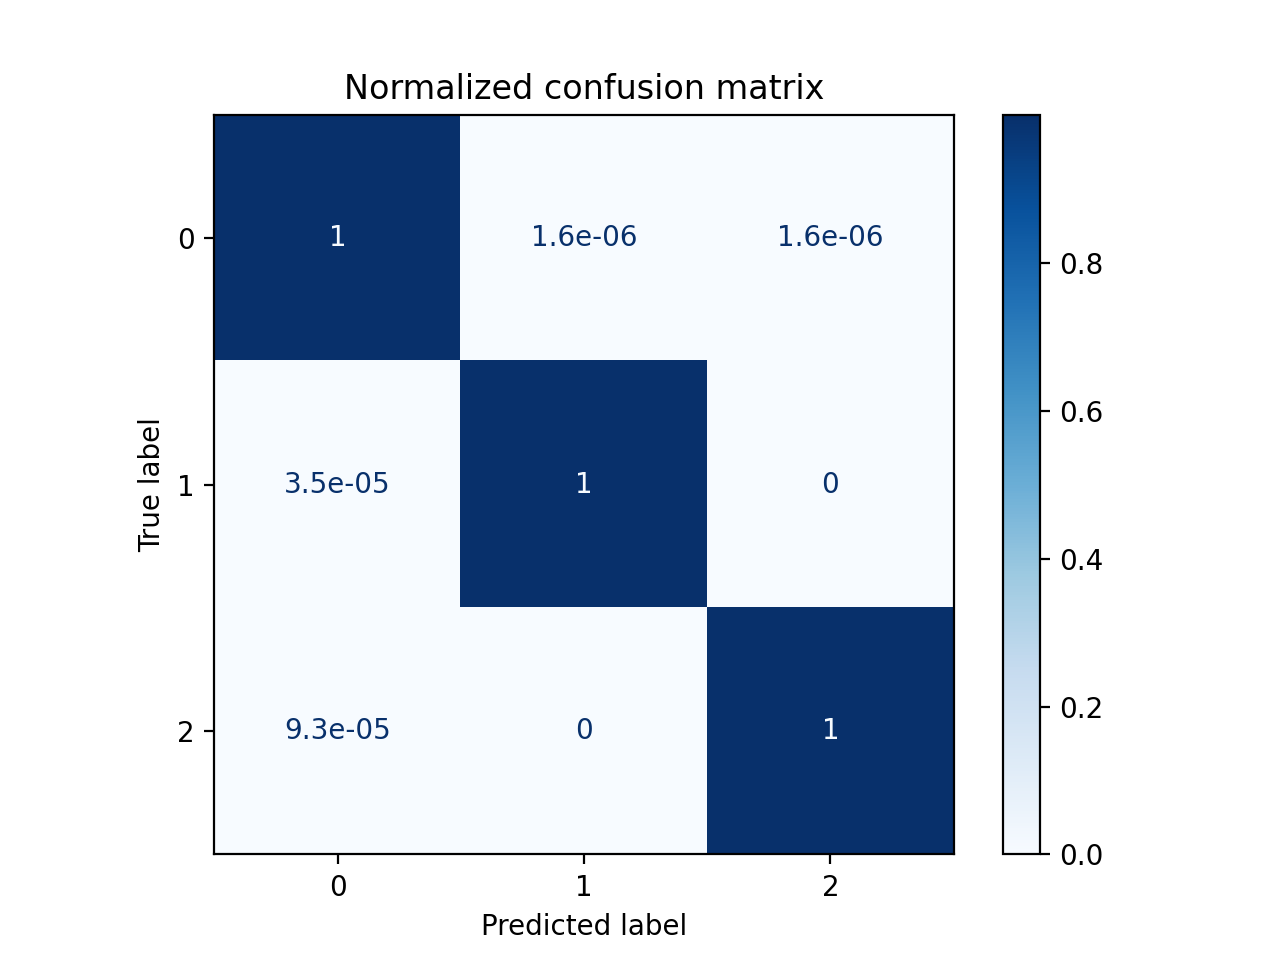

Normalized confusion matrix
[[1.00e+00 1.57e-06 1.57e-06]
 [3.50e-05 1.00e+00 0.00e+00]
 [9.27e-05 0.00e+00 1.00e+00]]


In [12]:
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=xgboostModel, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

# Ridge Classifier
I found that Ridge Classifier presents the same overfitting on the dataset. XGBoost would tend to classify the samples as class 0 but the Ridge classifier would tend to classify them as class 1 and 2.

Test Acc: 0.4743980696025362, Test F1: 0.33712751588397677


<IPython.core.display.Javascript object>


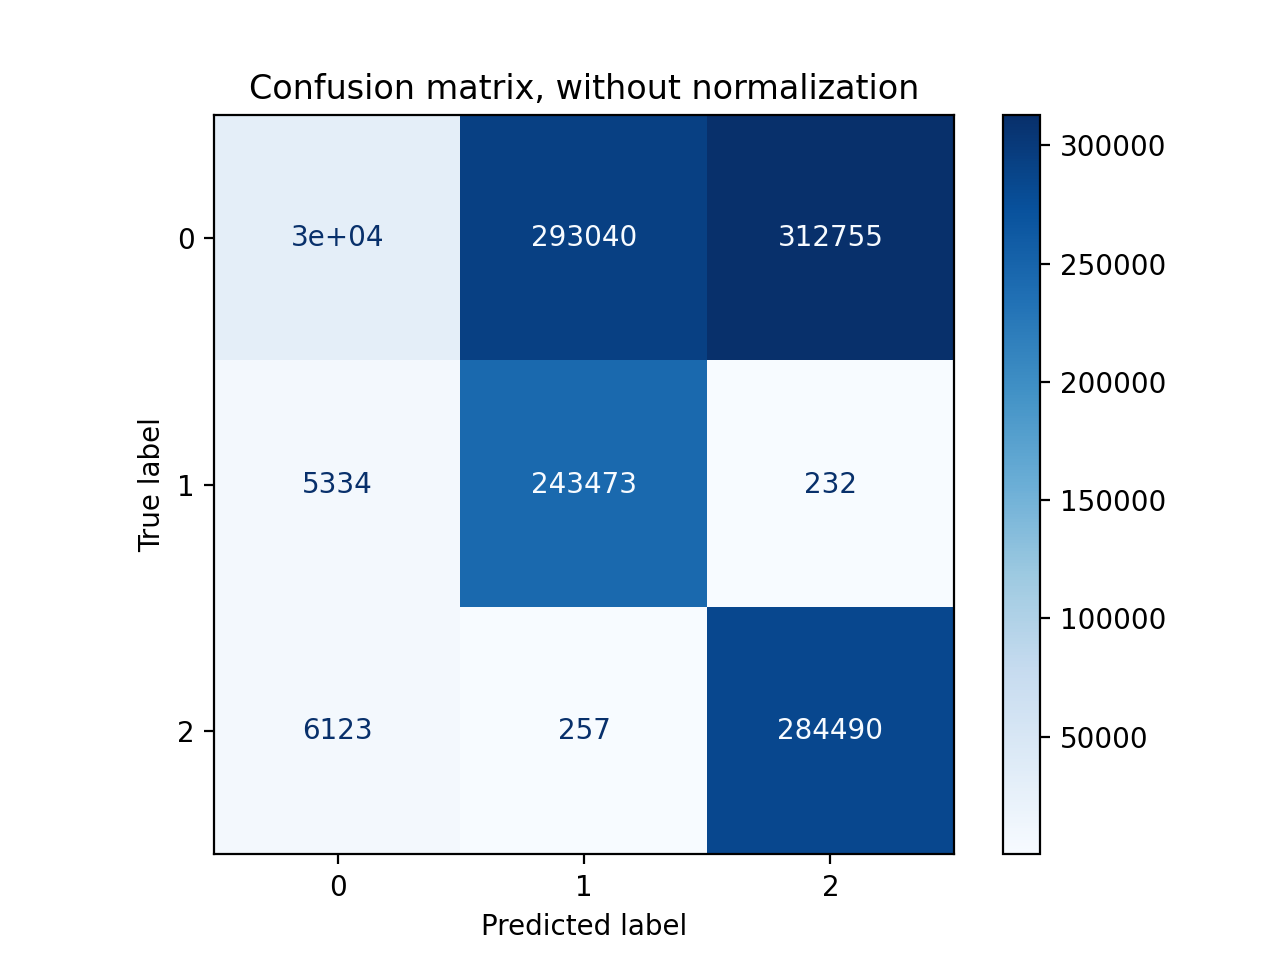

Confusion matrix, without normalization
[[ 29598 293040 312755]
 [  5334 243473    232]
 [  6123    257 284490]]


<IPython.core.display.Javascript object>


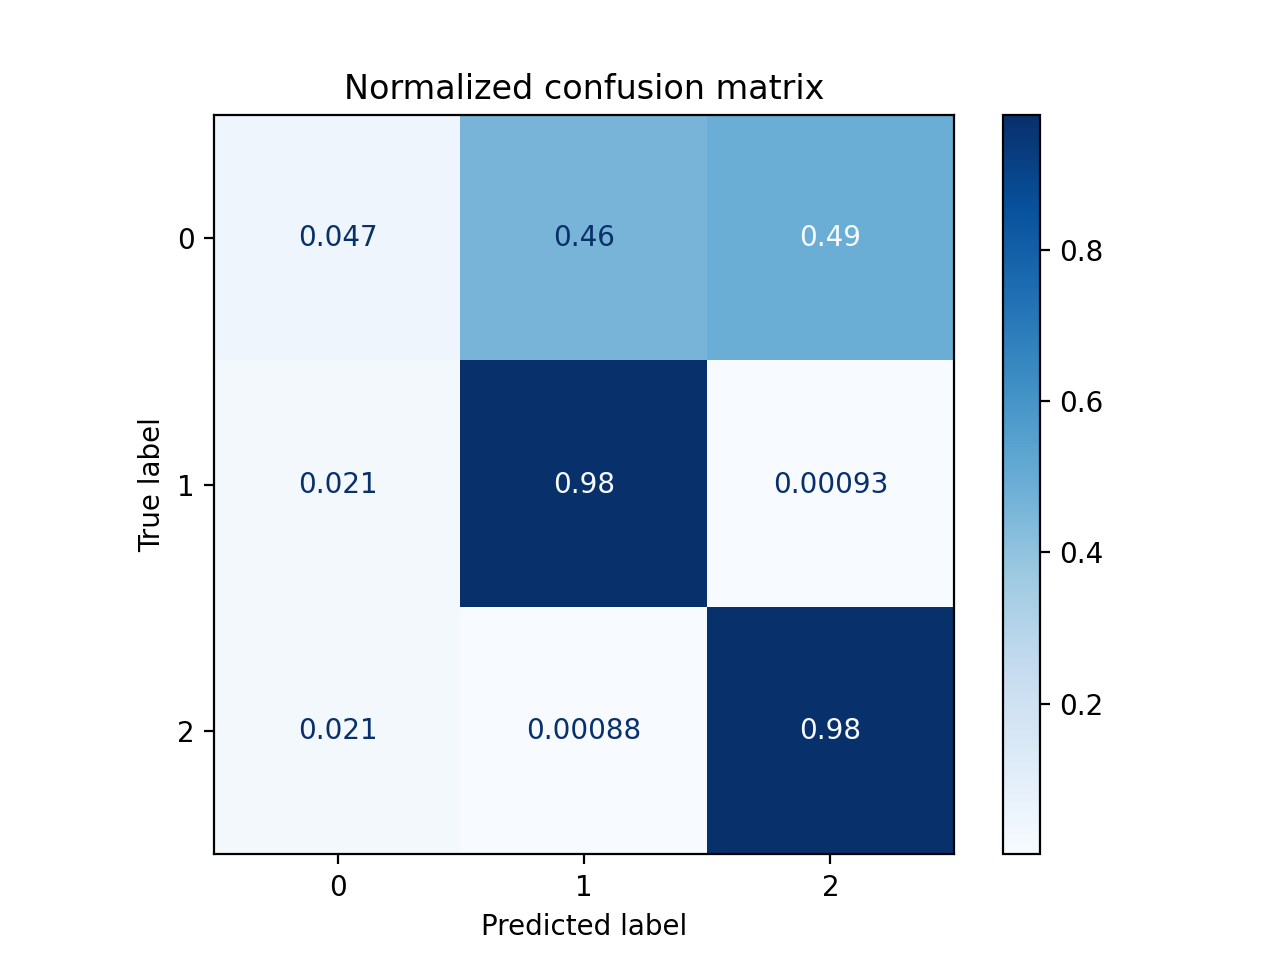

Normalized confusion matrix
[[4.66e-02 4.61e-01 4.92e-01]
 [2.14e-02 9.78e-01 9.32e-04]
 [2.11e-02 8.84e-04 9.78e-01]]
Train Acc: 0.4743903799274731, Train F1: 0.34259747343585


<IPython.core.display.Javascript object>


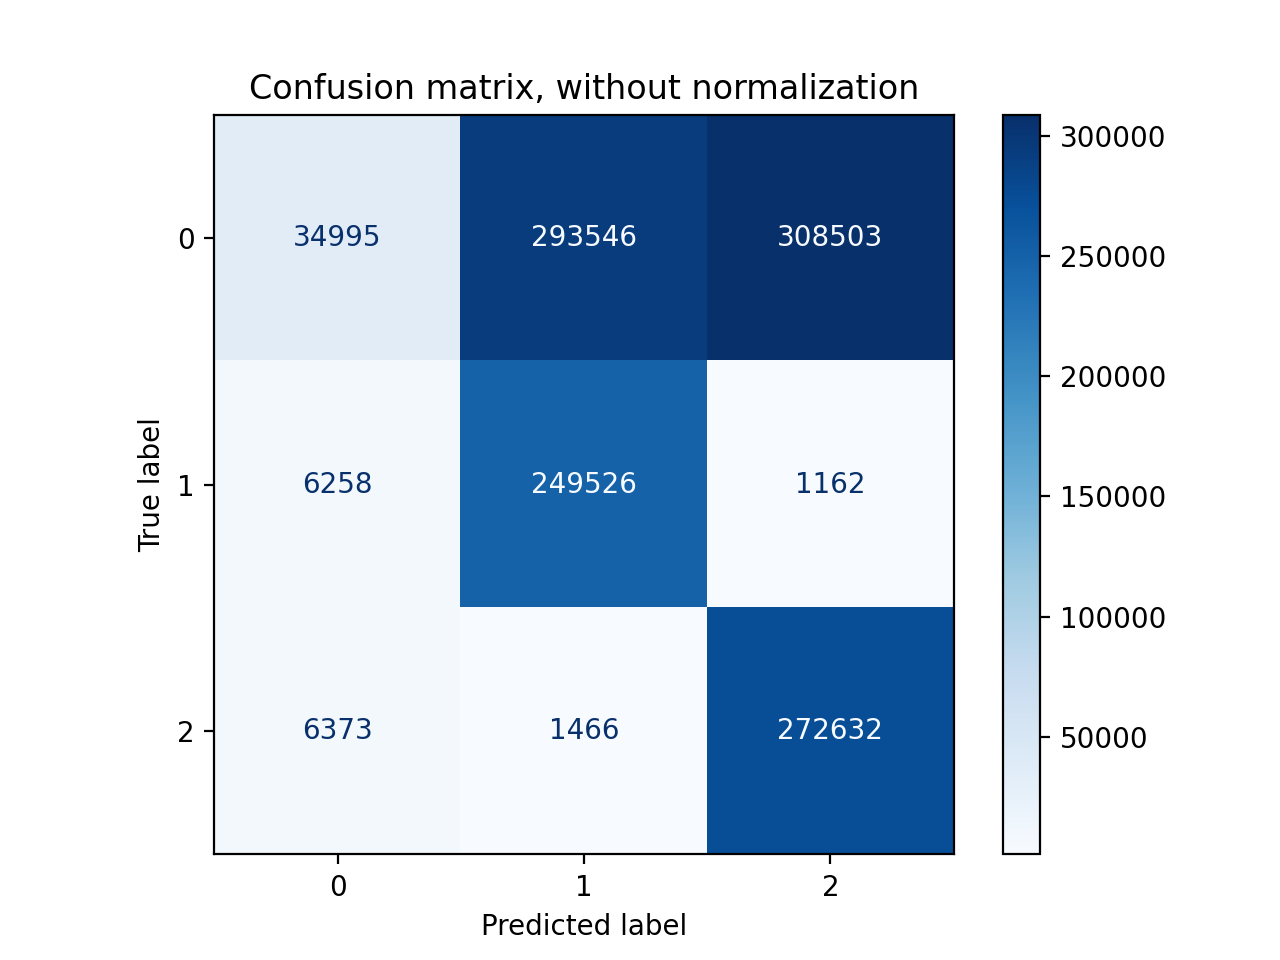

Confusion matrix, without normalization
[[ 34995 293546 308503]
 [  6258 249526   1162]
 [  6373   1466 272632]]


<IPython.core.display.Javascript object>


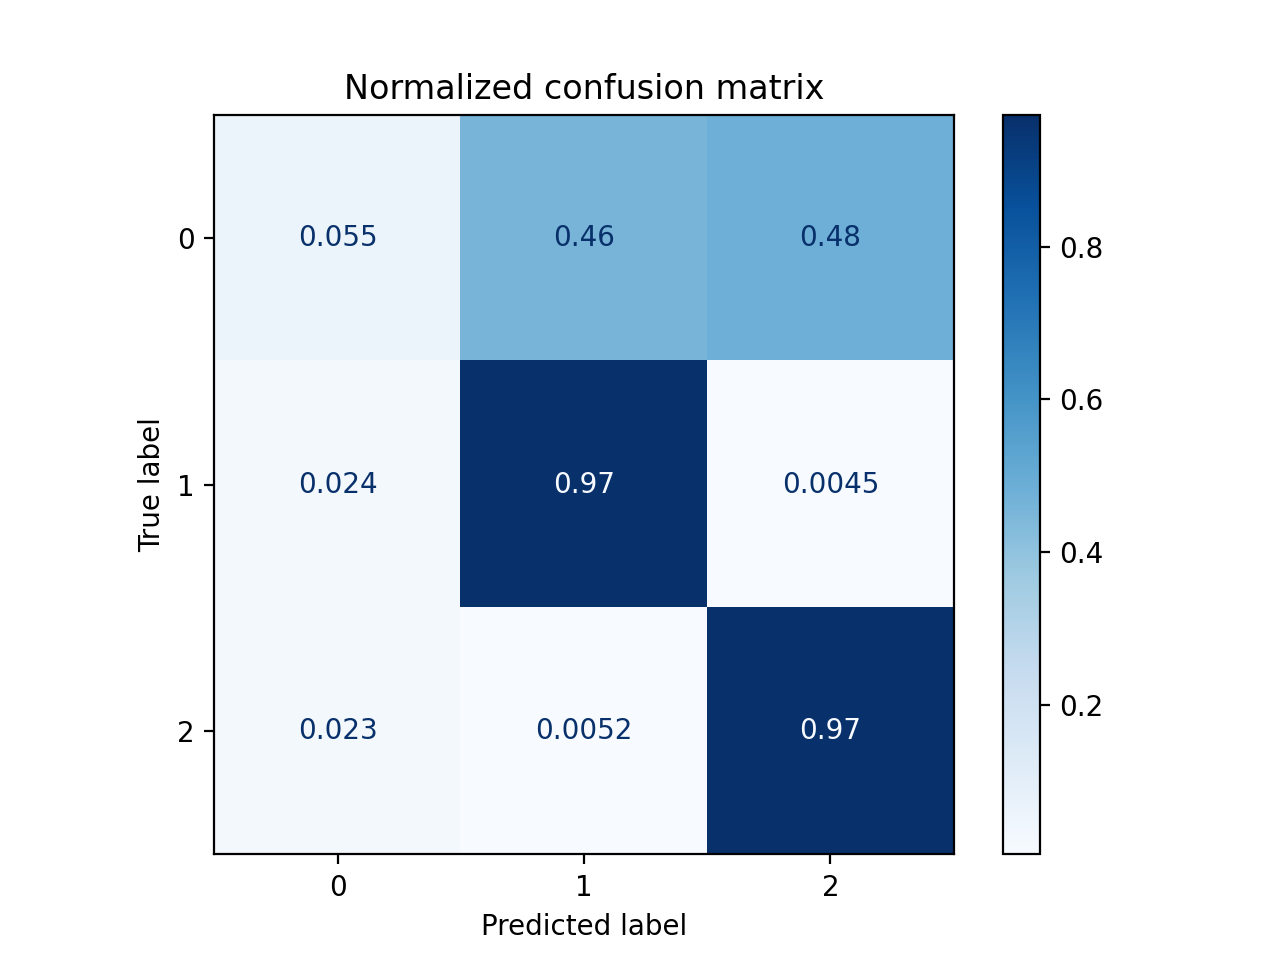

Normalized confusion matrix
[[0.05 0.46 0.48]
 [0.02 0.97 0.  ]
 [0.02 0.01 0.97]]


In [55]:
ridge_clf = RidgeClassifier(alpha=1, max_iter=10000, class_weight='balanced').fit(train_data_sc, train_labels)
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=ridge_clf, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

## (2) Outliners Filter
To eliminate the overfitting, I try Isolation Tree outliner filter to remove outliners. It yields a little bit performance enhancement, which is about 1% improvement on the accuracy and F1 score.

In [55]:
X_train_iso, y_train_iso = iso_trans(X_train=train_data_sc, y_train=train_labels)

(1164832, 70)
[[ 0.85 -0.71  0.14 ...  0.59  0.37  0.39]
 [ 1.13 -0.03  0.14 ...  0.59  0.37  0.39]
 [ 0.76 -0.03  0.14 ...  0.59  0.37  0.39]
 ...
 [ 0.33 -0.79 -0.24 ... -0.21 -0.18 -0.26]
 [ 0.33  1.54 -0.24 ... -0.21 -0.18 -0.26]
 [-0.69  0.02 -0.05 ... -0.21 -0.18 -0.26]]
Value Range: [-60.85795064477092:265.4388678920328]
(1164832,)
[1 1 0 ... 1 1 0]
Value Range: [0:2]


In [94]:
xgboostModel = XGBClassifier(n_estimators=100, max_depth=5)
xgboostModel.fit(X_train_iso, y_train_iso)
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=xgboostModel, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=X_train_iso, train_labels=y_train_iso)

KeyboardInterrupt: 

In [57]:
train_data_sc = X_train_iso
train_labels = y_train_iso

<IPython.core.display.Javascript object>


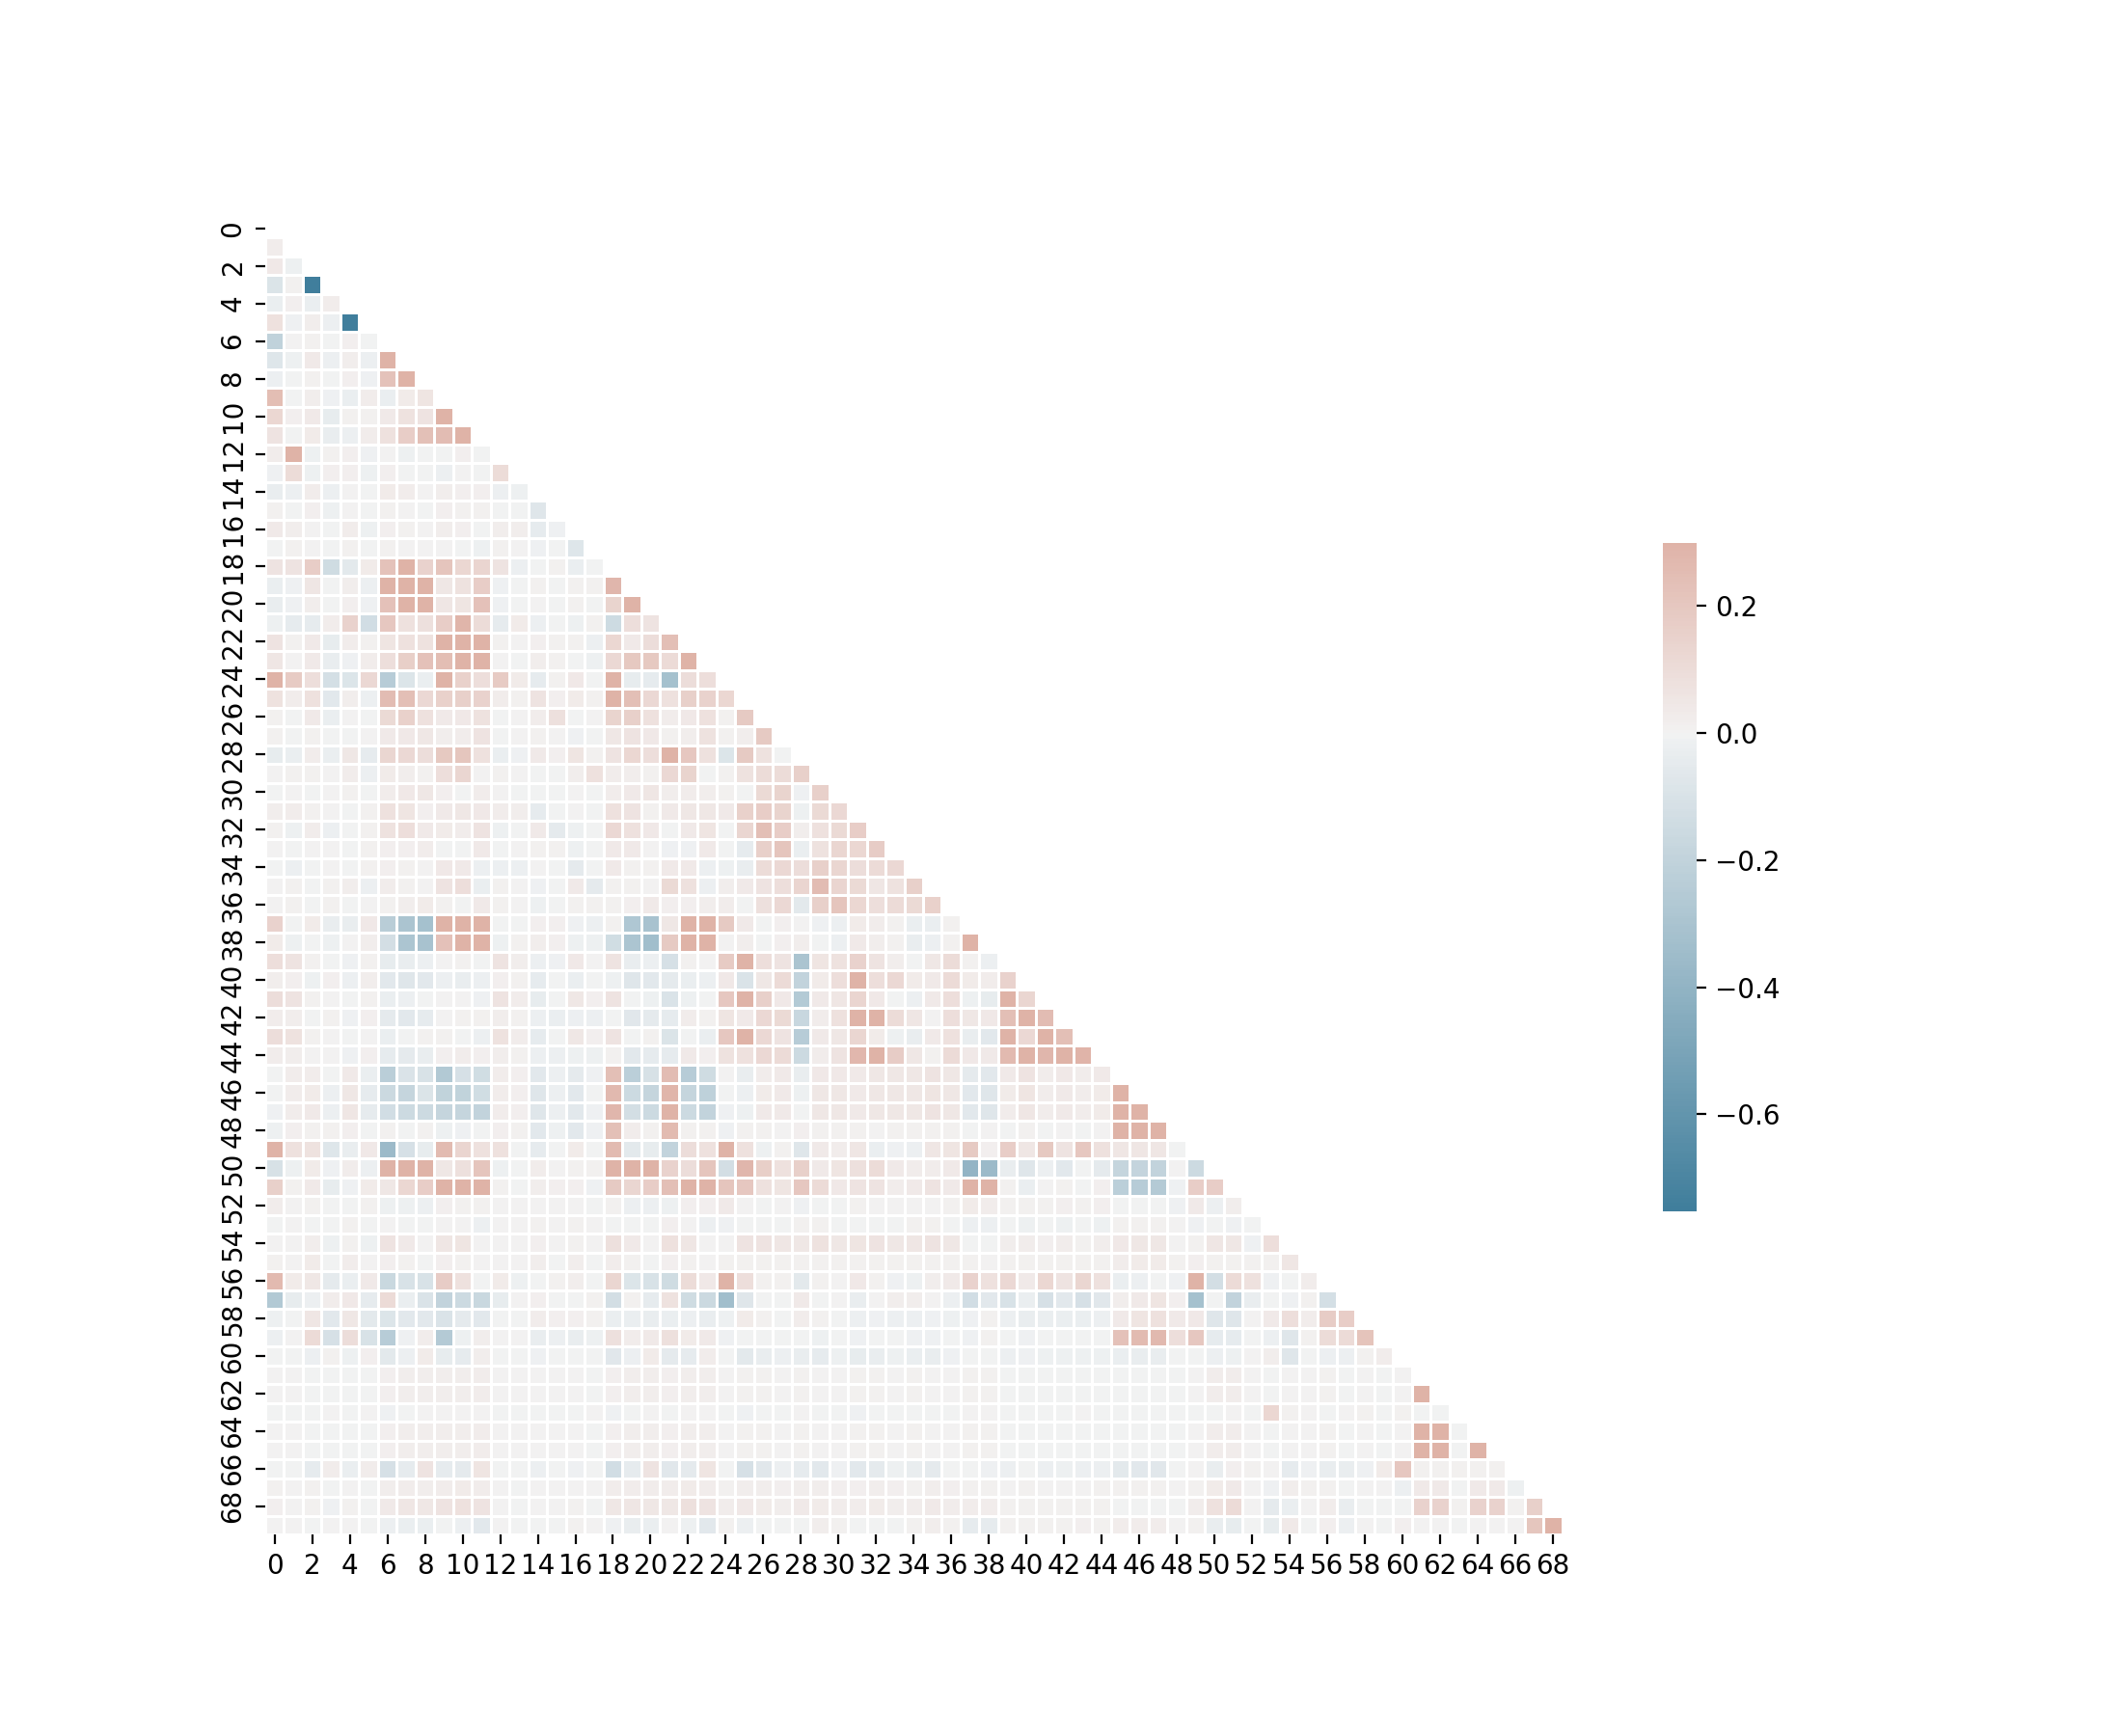

In [58]:
 correlation_map(train_data)

# TSNE Visualization
Here, I use TSNE to visualize the 10-dimension dataset. We can see that class 1 and class 2 can be determined easily but class 0 overlaps class 1 and 2, causing low accracy. This result can correspond to the results of ridge regression.

In [52]:
n_components = 2
params = {
    "n_neighbors": 12,
    "n_components": n_components,
    "eigen_solver": "auto",
    "random_state": 0,
}

manifold_X_train, _, manifold_y_train, _ = train_test_split(X_train_pca10, train_labels, train_size=0.001, shuffle=True, random_state=42)
color_map = ['tab:blue', 'tab:orange', 'tab:green']
S_color = [color_map[y] for y in manifold_y_train]

<IPython.core.display.Javascript object>


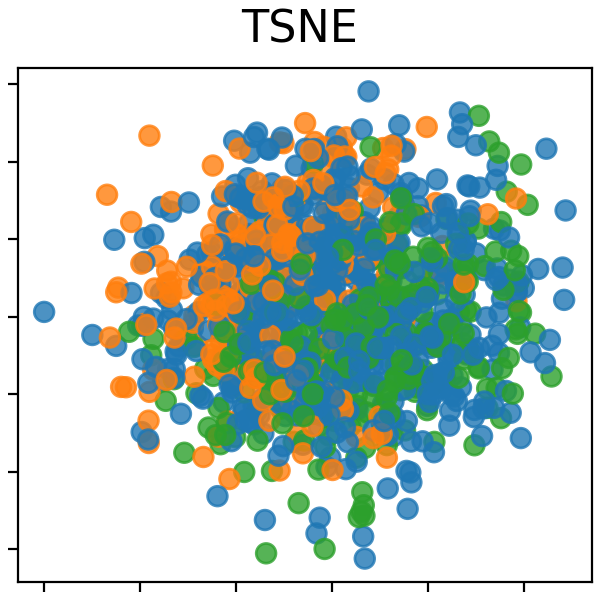

In [53]:
tsne = manifold.TSNE(n_components=n_components,
                    init="random",
                    perplexity=1000,
                    learning_rate="auto",
                    n_iter=300
                    ).fit_transform(manifold_X_train)

# plot_3d(tsne, S_color, "TSNE")
plot_2d(tsne, S_color, "TSNE")

# Potential Reason 3: Overly Complex Model
## (1) : XGBoost Grid Search with Full-Dimension Dataset
I've conducted a comprehensive grid search for searching best hyperparameters. The best parameter is shown below and the best score is about ?%. (The experiment is still runing. I will update when the experiment finish.)

In [70]:
param_stage3 = {
 'learning_rate': [0.01, 0.1, 0.5, 1],
 'gamma':[i/10.0 for i in range(0,5)],
 'max_depth': [5],
 'min_child_weight': [10, 100, 1000, 5000], 
 'subsample': [0.5, 0.8, 1],
 'colsample_bytree': [0.5, 0.8, 1],
 'reg_lambda': [0.01, 0.1, 0.5, 1, 5, 10],
#  'reg_alpha': [],
 'scale_pos_weight': [0.1, 0.5, 1],
}

xgb_gridsearch(params=param_stage3, file_name='gsearch_stage3', X_train=train_data_sc, y_train=train_labels)

/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [04:04:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [04:04:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [04:04:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [04:04:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/xgboos

In [93]:
with open('gsearch_stage3.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(grid_search.cv_results_)
print(f"Best Param: {grid_search.best_params_}")
print(f"Best F1-Score: {grid_search.best_score_:.3f}")
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

FileNotFoundError: [Errno 2] No such file or directory: 'gsearch_stage3.pkl'

## (2) : XGBoost Grid Search with 10-Dimension Dataset
I've also conducted grid search on 10-dimensional dataset. However, I found it will get overfitting much more easily. The best testing accuracy is about 55%, which is worse than full-dimensions (70 features).

In [ ]:
param_stage1 = {
 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
 'gamma':[i/10.0 for i in range(0,5)],
 'max_depth': [3, 5, 7, 10, 15, 20],
 'min_child_weight': [10, 100, 1000], 
 'subsample': [0.8],
 'colsample_bytree': [0.8],
 'scale_pos_weight': [1],
}

param_stage2 = {
 'learning_rate': [0.5],
 'gamma':[0.2],
 'max_depth': [10],
 'min_child_weight': [10, 100, 1000, 5000, 10000], 
 'subsample': [0.5, 0.8, 1],
 'colsample_bytree': [0.5, 0.8, 1],
 'reg_lambda': [0.01, 0.1, 0.5, 1, 10],
#  'reg_alpha': [],
 'scale_pos_weight': [0.5, 1, 2],
}

xgb_gridsearch(params=param_stage2, file_name='gsearch_stage2', X_train=X_train_pca10, y_train=train_labels)

Best Param: {'colsample_bytree': 1, 'gamma': 0.2, 'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 1000, 'reg_lambda': 1, 'scale_pos_weight': 0.5, 'subsample': 1}
Best F1-Score: 0.552
Test Acc: 0.550, Test F1: 0.535, Test Precision: 0.543, Test Recall: 0.550


<IPython.core.display.Javascript object>


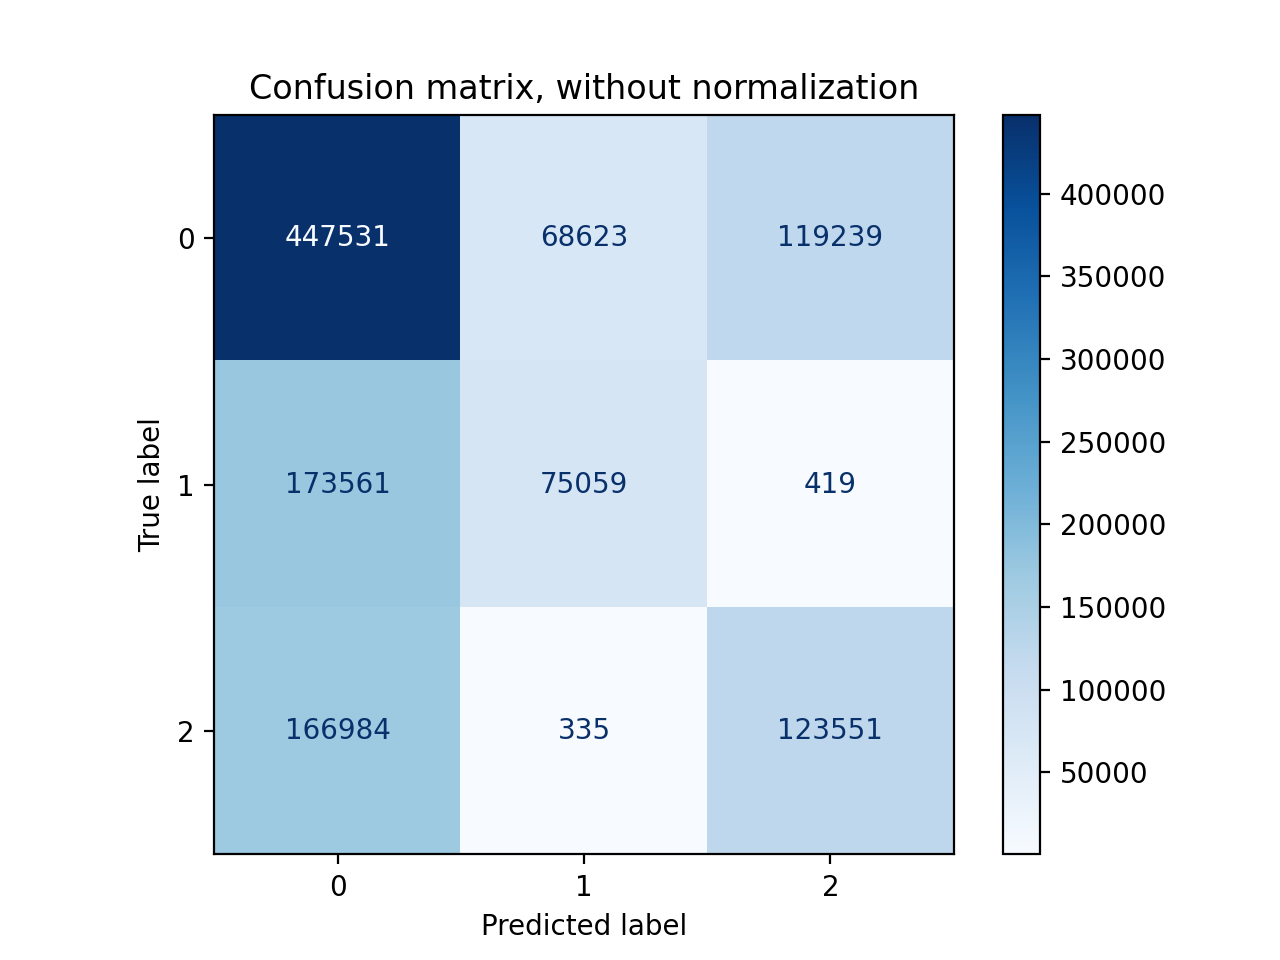

Confusion matrix, without normalization
[[447531  68623 119239]
 [173561  75059    419]
 [166984    335 123551]]


<IPython.core.display.Javascript object>


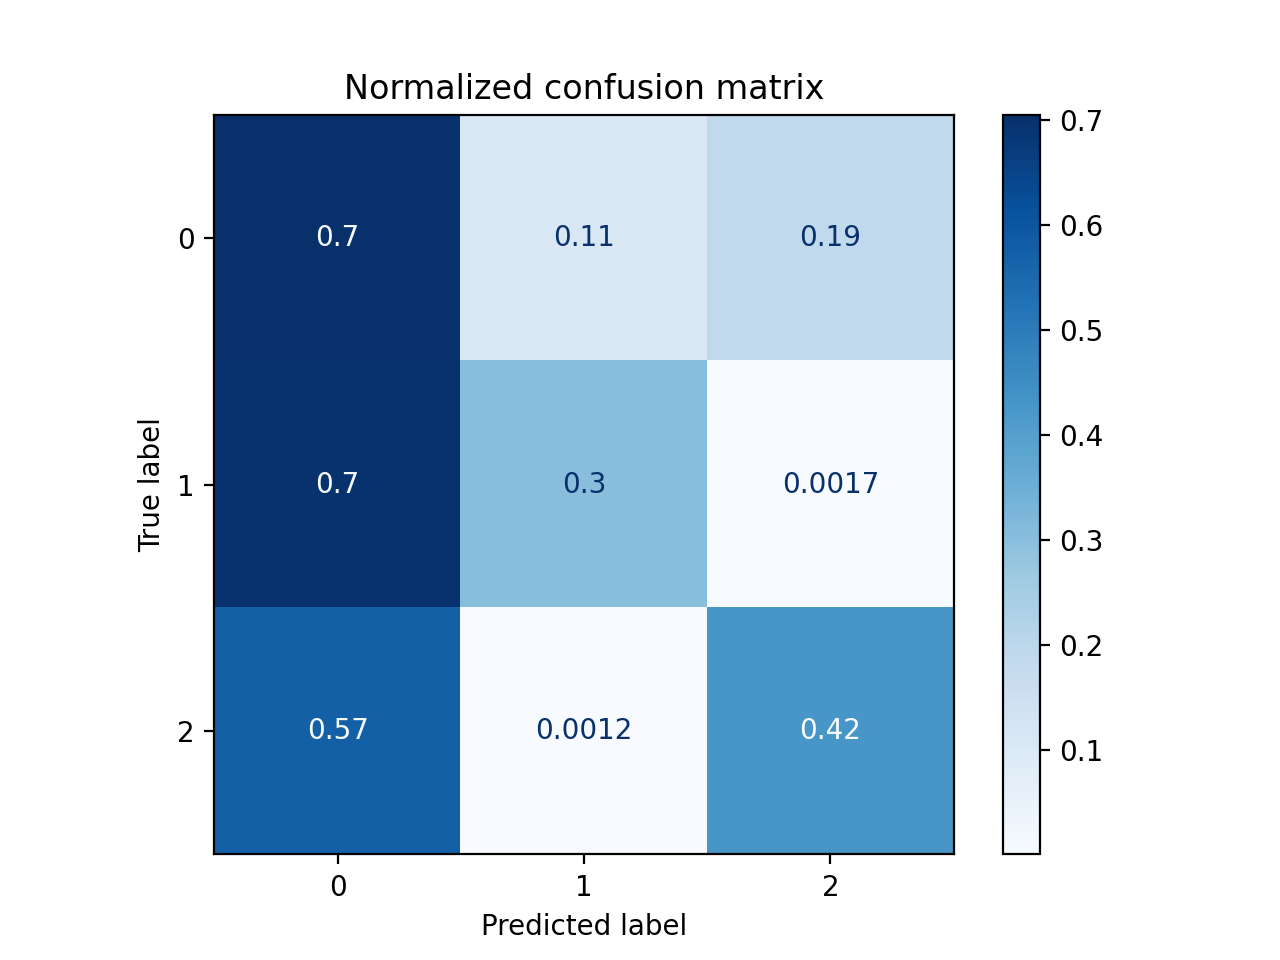

Normalized confusion matrix
[[0.7  0.11 0.19]
 [0.7  0.3  0.  ]
 [0.57 0.   0.42]]
Train Acc: 0.563, Train F1: 0.544, Train Precision: 0.557, Train Recall: 0.563


<IPython.core.display.Javascript object>


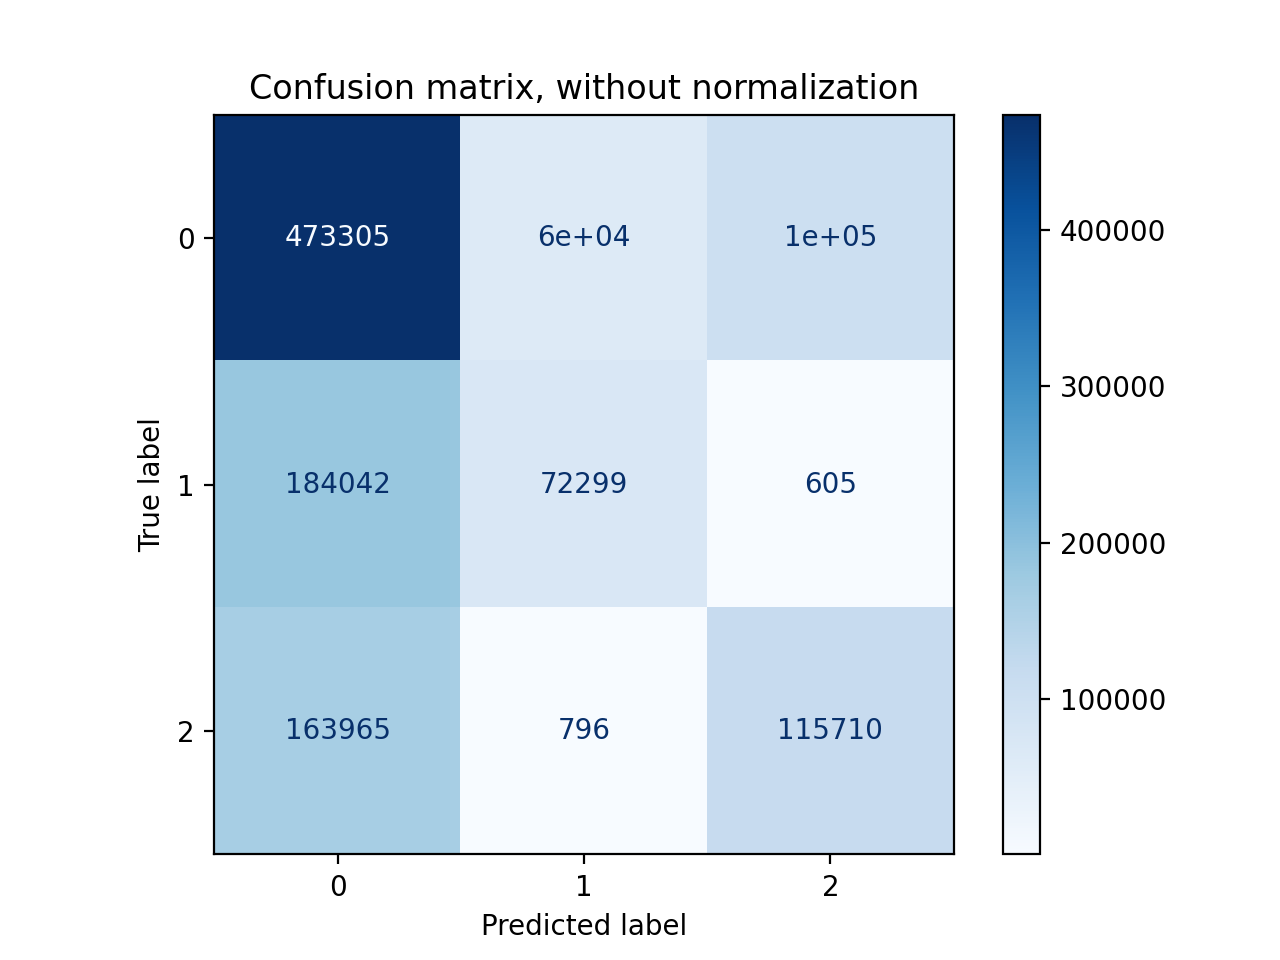

Confusion matrix, without normalization
[[473305  59849 103890]
 [184042  72299    605]
 [163965    796 115710]]


<IPython.core.display.Javascript object>


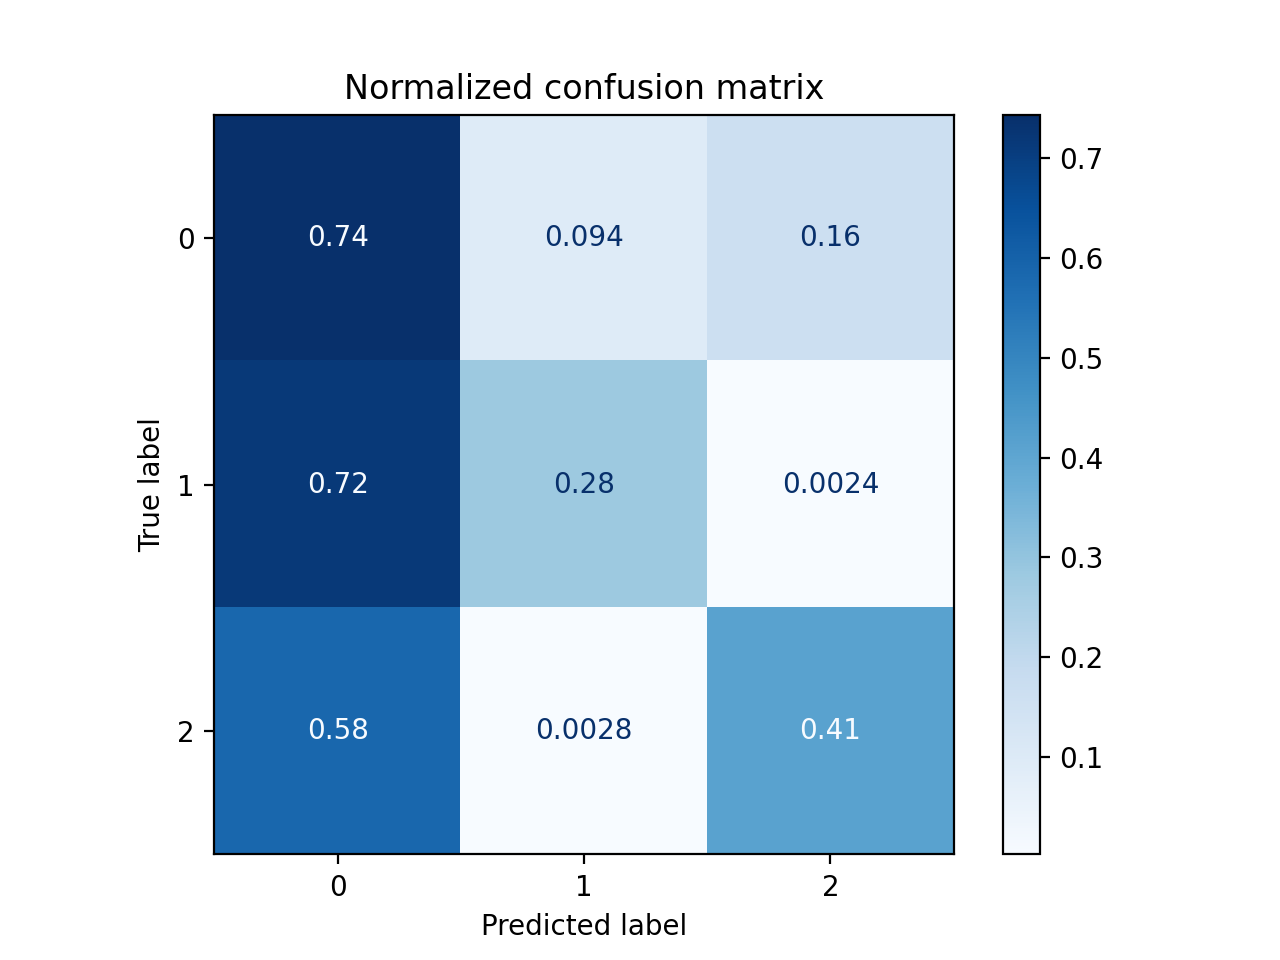

Normalized confusion matrix
[[0.74 0.09 0.16]
 [0.72 0.28 0.  ]
 [0.58 0.   0.41]]


In [92]:
with open('gsearch_stage2.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(grid_search.cv_results_)
print(f"Best Param: {grid_search.best_params_}")
print(f"Best F1-Score: {grid_search.best_score_:.3f}")
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=X_test_pca10, eval_labels=eval_labels, train_data=X_train_pca10, train_labels=train_labels)

# Try Deep Neural Network (DNN)
During the grid search, I also tried a complex model because other model, like support vector machine (SVM) and ridge classifier, usually perform badly or takes very long time to train. Although DNN is a very complex model, which may cause more severe overfitting, we can still leverage L2 regularization, batch normalization, noisy augmentation, and drop out as the solution.

In [101]:
batch_size: int = 8192
device: str = 'cuda:1'
n_class: int = 3
n_feature: int = 70
epoch: int = 100
lr: float = 0.01
model_name: str = f"dnn_d{n_feature}_lr{lr}_ep{epoch}"

# X_train_pca10, X_test_pca10 = pca_trans(n_components=10, X_train=train_data_sc, X_test=eval_data_sc)
X_train_tsr = torch.Tensor(train_data_sc).to(device)
# X_train_tsr = torch.Tensor(X_train_pca10).to(device)
y_train_tsr = torch.Tensor(train_labels).long().to(device)
X_test_tsr = torch.Tensor(eval_data_sc).to(device)
# X_test_tsr = torch.Tensor(X_test_pca10).to(device)
y_test_tsr = torch.Tensor(eval_labels).long().to(device)

ds_train = TensorDataset(X_train_tsr, y_train_tsr)
dl_train = DataLoader(ds_train, batch_size=batch_size)
ds_test = TensorDataset(X_test_tsr, y_test_tsr)
dl_test = DataLoader(ds_test, batch_size=batch_size)

print(f"X_train_tsr: {X_train_tsr.shape}")
print(f"y_train_tsr: {y_train_tsr.shape}")

X_train_tsr: torch.Size([1174461, 70])
y_train_tsr: torch.Size([1174461])


In [96]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_feature, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, n_class)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [97]:
for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = []
#     with tqdm(total=100) as pbar:
    for i, data in tqdm(enumerate(dl_train, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())
        
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {sum(running_loss) / len(running_loss):.3f}')
    running_loss = []
#             pbar.update(1)
torch.save(net.state_dict(), model_name)
print('Finished Training')

144it [00:38,  3.75it/s]


[1,   144] loss: 0.698


144it [00:40,  3.56it/s]


[2,   144] loss: 0.674


144it [00:46,  3.12it/s]


[3,   144] loss: 0.671


144it [00:44,  3.23it/s]


[4,   144] loss: 0.669


144it [00:39,  3.68it/s]


[5,   144] loss: 0.667


144it [00:40,  3.57it/s]


[6,   144] loss: 0.666


144it [00:45,  3.19it/s]


[7,   144] loss: 0.666


144it [00:42,  3.36it/s]


[8,   144] loss: 0.665


144it [00:41,  3.48it/s]


[9,   144] loss: 0.664


144it [00:41,  3.51it/s]


[10,   144] loss: 0.663


144it [00:41,  3.49it/s]


[11,   144] loss: 0.663


144it [00:39,  3.62it/s]


[12,   144] loss: 0.663


144it [00:44,  3.27it/s]


[13,   144] loss: 0.663


144it [00:41,  3.50it/s]


[14,   144] loss: 0.662


144it [00:43,  3.31it/s]


[15,   144] loss: 0.662


144it [00:42,  3.37it/s]


[16,   144] loss: 0.661


144it [00:40,  3.60it/s]


[17,   144] loss: 0.661


144it [00:41,  3.49it/s]


[18,   144] loss: 0.661


144it [00:40,  3.59it/s]


[19,   144] loss: 0.660


144it [00:40,  3.56it/s]


[20,   144] loss: 0.660


144it [00:39,  3.61it/s]


[21,   144] loss: 0.659


144it [00:43,  3.28it/s]


[22,   144] loss: 0.659


144it [00:44,  3.23it/s]


[23,   144] loss: 0.659


144it [00:45,  3.15it/s]


[24,   144] loss: 0.659


144it [00:45,  3.20it/s]


[25,   144] loss: 0.658


144it [00:39,  3.66it/s]


[26,   144] loss: 0.658


144it [00:43,  3.30it/s]


[27,   144] loss: 0.658


144it [00:39,  3.65it/s]


[28,   144] loss: 0.658


144it [00:47,  3.06it/s]


[29,   144] loss: 0.658


144it [00:43,  3.28it/s]


[30,   144] loss: 0.658


144it [00:43,  3.32it/s]


[31,   144] loss: 0.658


144it [00:44,  3.26it/s]


[32,   144] loss: 0.657


144it [00:47,  3.06it/s]


[33,   144] loss: 0.657


144it [00:49,  2.93it/s]


[34,   144] loss: 0.657


144it [00:42,  3.35it/s]


[35,   144] loss: 0.657


144it [00:40,  3.56it/s]


[36,   144] loss: 0.657


144it [00:39,  3.67it/s]


[37,   144] loss: 0.657


144it [00:41,  3.45it/s]


[38,   144] loss: 0.656


144it [00:44,  3.23it/s]


[39,   144] loss: 0.656


144it [00:42,  3.39it/s]


[40,   144] loss: 0.656


144it [00:40,  3.53it/s]


[41,   144] loss: 0.655


144it [00:47,  3.01it/s]


[42,   144] loss: 0.655


144it [00:49,  2.93it/s]


[43,   144] loss: 0.655


144it [00:44,  3.21it/s]


[44,   144] loss: 0.656


144it [00:46,  3.09it/s]


[45,   144] loss: 0.655


144it [00:43,  3.32it/s]


[46,   144] loss: 0.655


144it [00:41,  3.49it/s]


[47,   144] loss: 0.655


144it [00:48,  2.98it/s]


[48,   144] loss: 0.655


144it [00:38,  3.74it/s]


[49,   144] loss: 0.654


144it [00:38,  3.77it/s]


[50,   144] loss: 0.654


144it [00:41,  3.51it/s]


[51,   144] loss: 0.657


144it [00:41,  3.48it/s]


[52,   144] loss: 0.657


144it [00:40,  3.59it/s]


[53,   144] loss: 0.656


144it [00:43,  3.32it/s]


[54,   144] loss: 0.654


144it [00:44,  3.27it/s]


[55,   144] loss: 0.654


144it [00:43,  3.27it/s]


[56,   144] loss: 0.654


144it [00:44,  3.25it/s]


[57,   144] loss: 0.655


144it [00:43,  3.29it/s]


[58,   144] loss: 0.654


144it [00:45,  3.19it/s]


[59,   144] loss: 0.654


144it [00:41,  3.49it/s]


[60,   144] loss: 0.654


144it [00:41,  3.45it/s]


[61,   144] loss: 0.653


144it [00:44,  3.24it/s]


[62,   144] loss: 0.653


144it [00:44,  3.25it/s]


[63,   144] loss: 0.653


144it [00:43,  3.33it/s]


[64,   144] loss: 0.653


144it [00:43,  3.33it/s]


[65,   144] loss: 0.653


144it [00:42,  3.39it/s]


[66,   144] loss: 0.653


144it [00:43,  3.29it/s]


[67,   144] loss: 0.653


144it [00:39,  3.66it/s]


[68,   144] loss: 0.653


144it [00:41,  3.43it/s]


[69,   144] loss: 0.653


144it [00:40,  3.56it/s]


[70,   144] loss: 0.652


144it [00:40,  3.59it/s]


[71,   144] loss: 0.652


144it [00:39,  3.61it/s]


[72,   144] loss: 0.652


144it [00:43,  3.33it/s]


[73,   144] loss: 0.653


144it [00:43,  3.28it/s]


[74,   144] loss: 0.652


144it [00:40,  3.53it/s]


[75,   144] loss: 0.652


144it [00:45,  3.13it/s]


[76,   144] loss: 0.652


144it [00:43,  3.31it/s]


[77,   144] loss: 0.652


144it [00:46,  3.10it/s]


[78,   144] loss: 0.652


144it [00:49,  2.89it/s]


[79,   144] loss: 0.652


144it [00:44,  3.22it/s]


[80,   144] loss: 0.653


144it [00:45,  3.19it/s]


[81,   144] loss: 0.652


144it [00:44,  3.20it/s]


[82,   144] loss: 0.652


144it [00:45,  3.14it/s]


[83,   144] loss: 0.652


144it [00:44,  3.22it/s]


[84,   144] loss: 0.652


144it [00:46,  3.06it/s]


[85,   144] loss: 0.652


144it [00:45,  3.19it/s]


[86,   144] loss: 0.653


144it [00:45,  3.19it/s]


[87,   144] loss: 0.652


144it [00:47,  3.05it/s]


[88,   144] loss: 0.652


144it [00:46,  3.07it/s]


[89,   144] loss: 0.651


144it [00:41,  3.46it/s]


[90,   144] loss: 0.651


144it [00:45,  3.16it/s]


[91,   144] loss: 0.651


144it [00:45,  3.18it/s]


[92,   144] loss: 0.651


144it [00:44,  3.21it/s]


[93,   144] loss: 0.651


144it [00:43,  3.28it/s]


[94,   144] loss: 0.651


144it [00:41,  3.44it/s]


[95,   144] loss: 0.651


144it [00:44,  3.20it/s]


[96,   144] loss: 0.651


144it [00:44,  3.26it/s]


[97,   144] loss: 0.651


144it [00:41,  3.51it/s]


[98,   144] loss: 0.651


144it [00:43,  3.31it/s]


[99,   144] loss: 0.651


144it [00:41,  3.46it/s]

[100,   144] loss: 0.650
Finished Training


In [98]:
def dnn_eval(model, dl, device):
    model.eval()
    model = model.to(device)
    preds_list = []
    y_list = []
    for i, data in enumerate(dl, 0):
        inputs, labels = data
        outputs = model(inputs)
        preds_list.append(outputs)    
        y_list.append(labels)
    preds = torch.cat(preds_list, axis=0)
    ys = torch.cat(y_list, axis=0)
    
    f1 = multiclass_f1_score(preds, ys, num_classes=n_class, average='weighted')
    acc = multiclass_accuracy(preds, ys, num_classes=n_class)
    precision = multiclass_precision(preds, ys, num_classes=n_class, average='weighted')
    recall = multiclass_recall(preds, ys, num_classes=n_class, average='weighted')
#     print(f"Acc: {acc:.3f}, F1 Score: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")
    return preds, acc, f1, precision, recall

In [99]:
model = Net()
model.load_state_dict(torch.load(model_name))
preds, acc, f1, precision, recall = dnn_eval(model=model, dl=dl_test, device=device)
print(f"Test Acc: {acc:.3f}, F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

preds, acc, f1, precision, recall = dnn_eval(model=model, dl=dl_train, device=device)
print(f"Train Acc: {acc:.3f}, F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

Test Acc: 0.592, F1: 0.587, Precision: 0.589, Recall: 0.592
Train Acc: 0.616, F1: 0.611, Precision: 0.613, Recall: 0.616


# Final Conclusion
The best XGBoost model is 59% and best DNN is 59%. Both XGBoost and DNNs achieve similar accuracy and 